In [76]:
from random import randrange
from pandas import Series
from pylab import rcParams
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn import preprocessing
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib.pyplot as plt 
import warnings
import math
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


warnings.filterwarnings("ignore")

print('scipy: %s' % scipy.__version__)
print('numpy: %s' % np.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('pandas: %s' % pd.__version__)
print('sklearn: %s' % sklearn.__version__)
print('statsmodels: %s' % statsmodels.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [77]:
def adjust(val, length= 6): return str(val).ljust(length)

In [78]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [79]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [80]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def verifyErrors(forecast,actual,colunas):        
    for i in colunas:
        print(i)
        itemI = i.replace('_forecast','')
        print(f'Forecast Accuracy of: {itemI}')
        accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR2_test[itemI])
        for k, v in accuracy_prod.items():
            print(adjust(k), ': ', round(v,4))
        print('\n')

In [81]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [82]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS     
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C


<div class="alert alert-info"><h1> Configuracoes gerais 
</h1>
    <hr/>        
</div>


In [83]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]

#definicao da granularidade para uso rapido
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()

#tamanho padrao das figuras
figsize=(12,8)
#campo a ser analisada a serie temporal
field = 'total'
#Porcentagem do Teste em relação ao treino
testPercentSize=20
#quantos periodos a frente deve ser feita a predição
predictFieldPeriod=12
#indique a sazonalidade do periodo
sazonalPeriod = 12 
#campos que serão analisados no VAR
VARFields = ['Apelação Cível', 'Agravo de Instrumento','Embargos de Declaração'
                    , 'Recurso Cível', 'Agravo','Apelação Crime',
                   'Habeas Corpus','Apelação e Reexame Necessário','Reexame Necessário','Recurso Crime']

#ESCOLHER QUAL A PERIODICIDADE PARA FAZER AS PREDICOES
dfChoosed = dfMonth.copy()


In [84]:
dfDiff = dfChoosed.copy()

while(adf_teste(dfDiff[field],'',False)[0] >0.05):    
    dfDiff[field] = diff(dfDiff[field],k_diff=1)
    dfDiff = dfDiff.dropna()

In [85]:
test_size = (len(dfDiff) - int((testPercentSize * len(dfDiff))/100))
trainDiff = dfDiff.iloc[:test_size]
testDiff = dfDiff.iloc[test_size:]    
train = dfChoosed[:'2016']
test = dfChoosed['2017':]

In [86]:
display(dfChoosed['2016':].head(3))

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2016-01-01    13437            4087                   2915   
2016-02-01    23140            5048                   6513   
2016-03-01    35464            9415                   7982   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2016-01-01                       907           2568     598             593   
2016-02-01                      3220           2567    1424            1215   
2016-03-01                      5007           2428    2923            2395   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2016-01-01              711                            312   
2016-02-01              927                            895   
2016-03-01             1654                           1153   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2016-01-01                   164  ...                1              0   
2016-02-01                   565  ...                1              0   
2016-03-01                   573  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2016-01-01                        1                                   3   
2016-02-01                        1                                   0   
2016-03-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2016-01-01                                      0   
2016-02-01                                      1   
2016-03-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2016-01-01                               0                   0       99   
2016-02-01                               0                   0       84   
2016-03-01                               3                   1       90   

              weekType  Feriado  
judgmentDate                     
2016-01-01          21       30  
2016-02-01          21       29  
2016-03-01          23       31  

[3 rows x 50 columns]

In [87]:
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(dfChoosed[field], model='additive', freq=12)

dfChoosedAnalisys = dfChoosed[[field]].copy()
dfChoosedAnalisys['month'] = dfChoosedAnalisys.index.month
rcParams['figure.figsize'] = 15, 8

<div class="alert alert-info"><h1>  Analise do período de sazonalidade 
</h1>
    <hr/>        
</div>

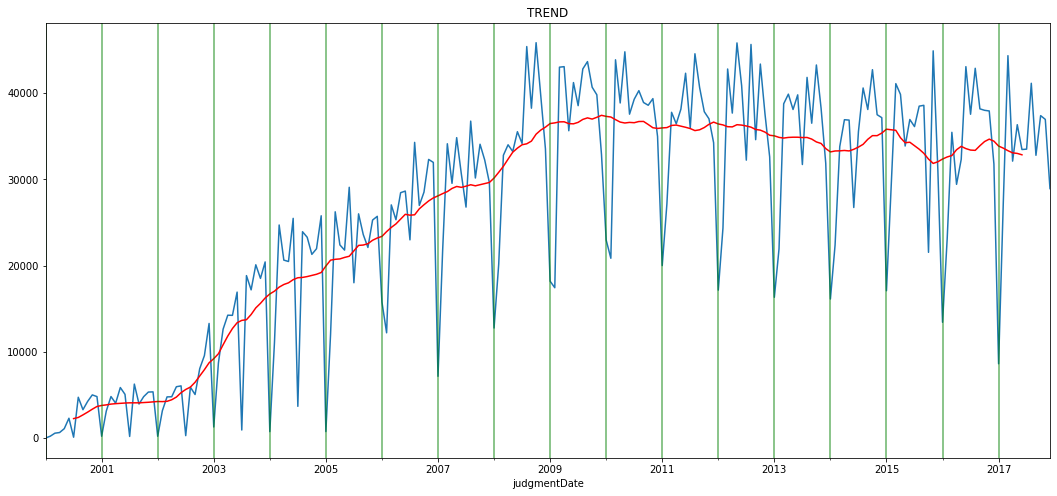

In [88]:
result_YM = seasonal_decompose(dfMonth[field],model='mul')

ax = result.observed.rename('Dados Observados').plot(figsize=(18,8))
result_YM.trend.plot(title='TREND', color='red')

ax.autoscale(axis='x',tight=True)
for x in dfChoosedAnalisys[[field,'month']].query('month==1').index: 
    ax.axvline(x=x, color='green', alpha = 0.6);


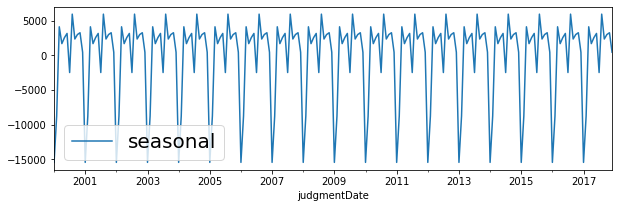

In [89]:
result.seasonal.plot(figsize=(10,3),legend=True);

<div class="alert alert-info"><h1> Smoothing
</h1>
    <hr/>    
    <h3>Simple - Exponential - EWM - ETS (Holt-Winters)</h3>
</div>

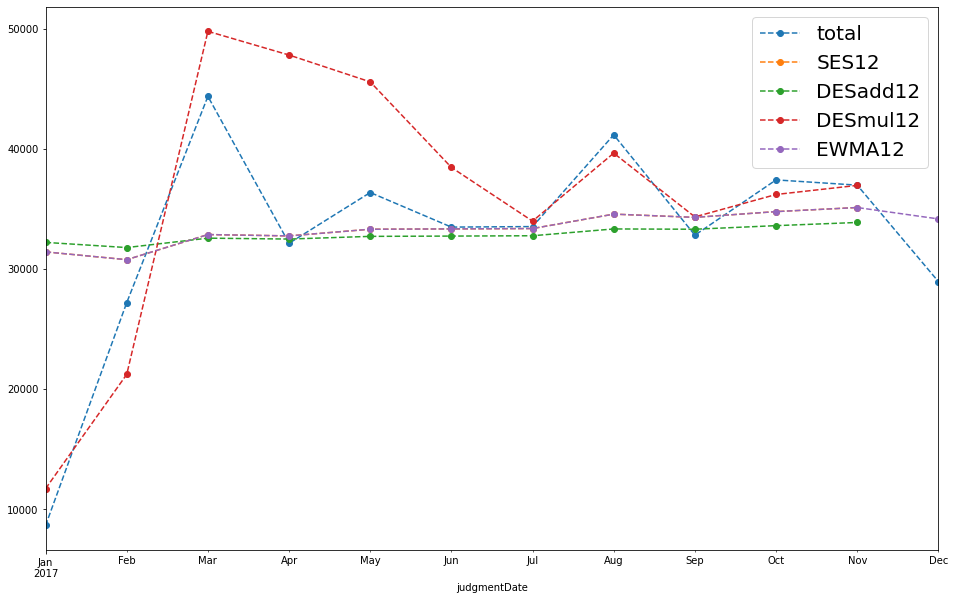

SES12 8146.789424440841
DESadd12 8614.497608377584
DESmul12 6295.996038376754
EWMA12 7943.881107738442


In [90]:
dfSimpleExpSmooth = dfChoosed.dropna()
dfSimpleExpSmooth = dfSimpleExpSmooth[[field]]

span = predictFieldPeriod
alpha = 2/(span+1)

SimpleExpSmoothFields = [field]

dfSimpleExpSmooth['EWMA'+str(predictFieldPeriod)] = dfSimpleExpSmooth[field].ewm(alpha=alpha,adjust=True).mean()
dfSimpleExpSmooth['SES'+str(predictFieldPeriod)]= SimpleExpSmoothing(dfSimpleExpSmooth[field]).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfSimpleExpSmooth['DESadd'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='add').fit().fittedvalues.shift(-1)
try:
    dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='mul').fit().fittedvalues.shift(-1)
except:
    print('erro mul')
    
dfSimpleExpSmooth[[field,'SES12', 'DESadd12', 'DESmul12','EWMA12']].tail(12).plot(style='--', marker='o',figsize=(16,10)).autoscale(axis='x',tight=True)
plt.show()

print("SES12",forecast_accuracy(dfSimpleExpSmooth['SES12'][-12:],dfChoosed[field][-12:])['rmse'])
print("DESadd12",forecast_accuracy(dfSimpleExpSmooth['DESadd12'][-12:],dfChoosed[field][-12:])['rmse'])
print("DESmul12",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-12:],dfChoosed[field][-12:])['rmse'])
print("EWMA12",forecast_accuracy(dfSimpleExpSmooth['EWMA12'][-12:],dfChoosed[field][-12:])['rmse'])


# Analise ponto a ponto

In [91]:
dfSimpleExpSmooth[field+'_Ant'] = np.where((dfSimpleExpSmooth[field] > dfSimpleExpSmooth[field].shift()),'+',"-")
dfSimpleExpSmooth['EWMA12_Ant'] = np.where((dfSimpleExpSmooth['EWMA12'] > dfSimpleExpSmooth['EWMA12'].shift()),"+","-")
dfSimpleExpSmooth['SES12_Ant'] = np.where((dfSimpleExpSmooth['SES12'] > dfSimpleExpSmooth['SES12'].shift()),"+","-")
dfSimpleExpSmooth['DESadd12_Ant'] = np.where((dfSimpleExpSmooth['DESadd12'] > dfSimpleExpSmooth['DESadd12'].shift()),"+","-")
dfSimpleExpSmooth['DESmul12_Ant'] = np.where((dfSimpleExpSmooth['DESmul12'] > dfSimpleExpSmooth['DESmul12'].shift()),"+","-")
display(dfSimpleExpSmooth['2017':])

total        EWMA12         SES12      DESadd12      DESmul12  \
judgmentDate                                                                  
2017-01-01     8625  31405.625021  31405.625021  32195.598719  11694.015838   
2017-02-01    27182  30755.836557  30755.836557  31765.179648  21205.750478   
2017-03-01    44352  32847.554009  32847.554009  32548.570883  49770.766769   
2017-04-01    32122  32735.930316  32735.930316  32472.988146  47795.464777   
2017-05-01    36348  33291.633344  33291.633344  32697.525927  45561.563266   
2017-06-01    33469  33318.920522  33318.920522  32720.993907  38436.625122   
2017-07-01    33513  33348.778903  33348.778903  32749.247429  33966.110926   
2017-08-01    41151  34549.120610  34549.120610  33315.135738  39627.921123   
2017-09-01    32798  34279.717439  34279.717439  33291.341252  34318.950738   
2017-10-01    37399  34759.607064  34759.607064  33589.964054  36184.756602   
2017-11-01    36963  35098.590593  35098.590593  33854.822554  36941.207505   
2017-12-01    28936  34150.499732           NaN           NaN           NaN   

             total_Ant EWMA12_Ant SES12_Ant DESadd12_Ant DESmul12_Ant  
judgmentDate                                                           
2017-01-01           -          -         -            -            -  
2017-02-01           +          -         -            -            +  
2017-03-01           +          +         +            +            +  
2017-04-01           -          -         -            -            -  
2017-05-01           +          +         +            +            -  
2017-06-01           -          +         +            +            -  
2017-07-01           +          +         +            +            -  
2017-08-01           +          +         +            +            +  
2017-09-01           -          -         -            -            -  
2017-10-01           +          +         +            +            +  
2017-11-01           -          +         +            +            +  
2017-12-01           -          -         -            -            -

# Exponential Smoothing

In [92]:
dfSimpleExpSmoothTest = dfSimpleExpSmooth.copy()
dfSimpleExpSmoothTest=dfSimpleExpSmoothTest['2000-01-01':'2016-12-31']

fit1 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='mul', seasonal='add').fit(use_boxcox=True)
fit4 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='mul', seasonal='mul').fit(use_boxcox=True)

print("Exponential Smoothing (AddAdd): ",forecast_accuracy(dfChoosed[field][:-predictFieldPeriod],fit1.fittedvalues)['rmse'])
print("Exponential Smoothing (AddMul): ",forecast_accuracy(dfChoosed[field][:-predictFieldPeriod],fit2.fittedvalues)['rmse'])
print("Exponential Smoothing (MulAdd): ",forecast_accuracy(dfChoosed[field][:-predictFieldPeriod],fit3.fittedvalues)['rmse'])
print("Exponential Smoothing (MulMul) ",forecast_accuracy(dfChoosed[field][:-predictFieldPeriod],fit4.fittedvalues)['rmse'])


Exponential Smoothing (AddAdd):  4152.4816741591685
Exponential Smoothing (AddMul):  6287.661479724834
Exponential Smoothing (MulAdd):  4187.666897890512
Exponential Smoothing (MulMul)  8774.717466011634


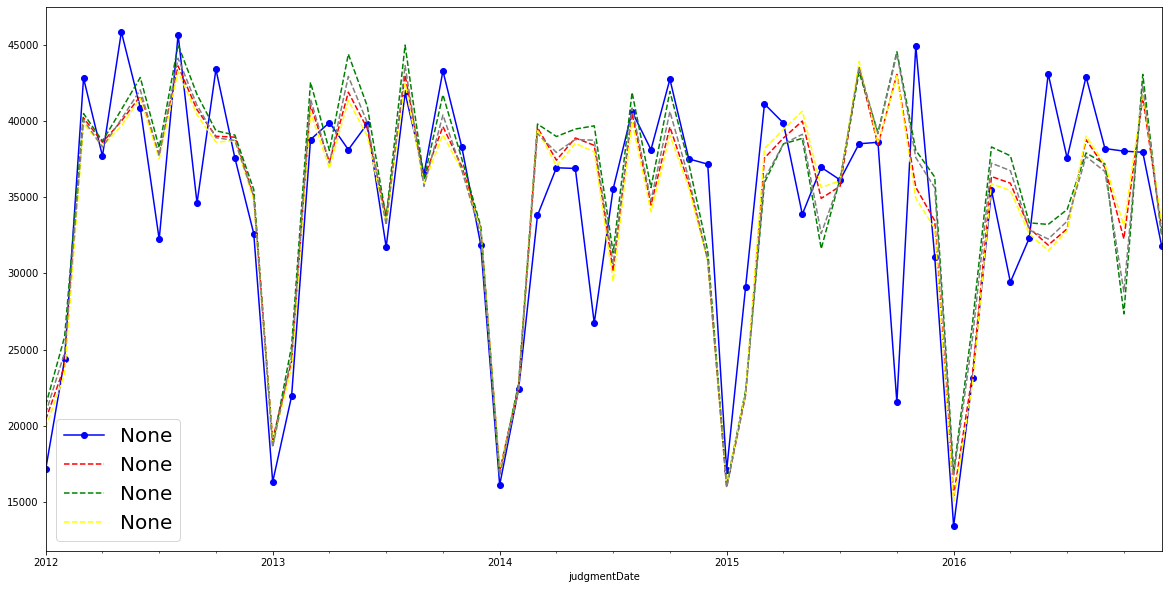

In [93]:
# comportamento da série inteira
ax = dfSimpleExpSmooth[field]['2012':'2016'].plot(figsize=(20,10), marker='o', color='blue')
fit1.fittedvalues['2012':'2017'].plot(ax=ax, style='--', color='red',legend=True)
fit2.fittedvalues['2012':'2017'].plot(ax=ax, style='--', color='green',legend=True)
fit3.fittedvalues['2012':'2017'].plot(ax=ax, style='--', color='yellow',legend=True)
fit4.fittedvalues['2012':'2017'].plot(ax=ax, style='--', color='gray',legend=True);

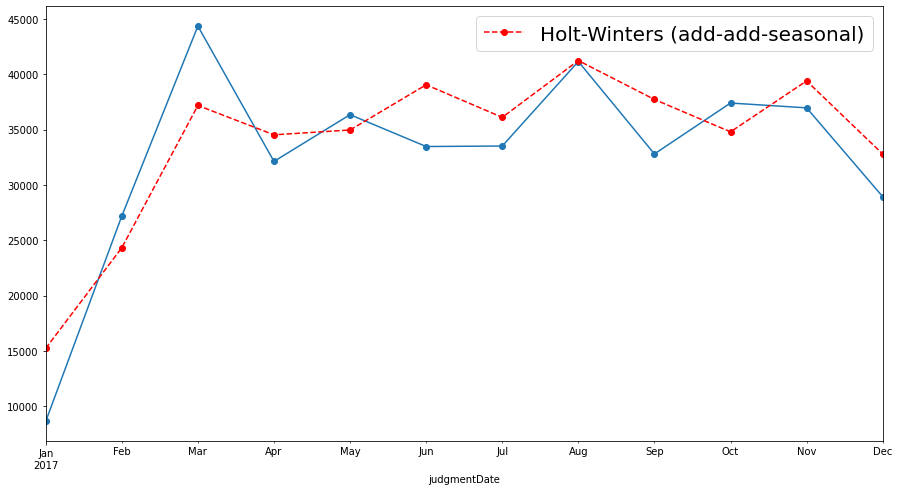

Exponential Smoothing (AddAdd):  4088.702543557596


In [94]:
fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
fit3.forecast(predictFieldPeriod).rename('Holt-Winters (mul-add-seasonal)').plot(ax=ax, style='--', marker='o', color='yellow', legend=True)
fit4.forecast(predictFieldPeriod).rename('Holt-Winters (mul-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='gray', legend=True)

#dfChoosed[field].plot()

HwForeCastAddAdd = fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)')
#HwForeCastAddMul = fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)')
#HwForeCastMulAdd = fit3.forecast(predictFieldPeriod).rename('Holt-Winters (mul-add-seasonal)')
#HwForeCastMulMul = fit4.forecast(predictFieldPeriod).rename('Holt-Winters (mul-mul-seasonal)')

dfChoosed[field]['2017':].plot(marker='o')
HwForeCastAddAdd.plot(style='--', marker='o', color='red', legend=True) 
#HwForeCastAddMul.plot(style='--', marker='o', color='green', legend=True) 
#HwForeCastMulAdd.plot(style='--', marker='o', color='yellow', legend=True)
#HwForeCastMulMul.plot(style='--', marker='o', color='black', legend=True)



plt.show()

#AddAdd Foi o melhor caso

print("Exponential Smoothing (AddAdd): ",forecast_accuracy(dfChoosed[field][-predictFieldPeriod:],HwForeCastAddAdd)['rmse'])

## COMPARATIVO ETS (Holt Winters) - DES multiplicative - Real Predito

DESmul12:                                6295.996038376754
Exponential Smoothing (AddAdd):          4088.702543557596


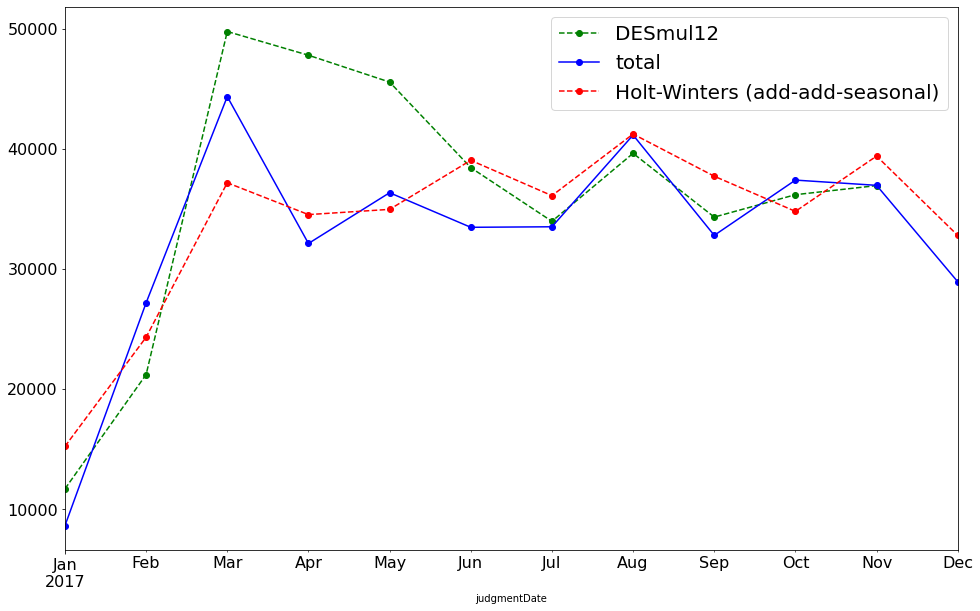

In [95]:
import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)

dfSimpleExpSmooth[['DESmul12']].tail(12).plot(figsize=(16,10),style='--', marker='o',color='green', fontsize = '16').legend(title_fontsize = '14')
dfChoosed[field]['2017':].plot(marker='o',legend=True, color='blue')
HwForeCastAddAdd.plot(style='--', marker='o', color='red', legend=True); 
print(adjust('DESmul12: ',40),forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-12:],dfChoosed[field][-12:])['rmse'])
print(adjust('Exponential Smoothing (AddAdd): ',40),forecast_accuracy(dfChoosed[field][-predictFieldPeriod:],HwForeCastAddAdd)['rmse'])
ax.tick_params(labelsize=6)

<div class="alert alert-info"><h1> Autoregressive Model
</h1>
    <hr/>    
    <h3>AR,ARIMA,SARIMA</h3>
</div>

In [96]:
dfChoosedAR = dfChoosed.copy()
dfDiffAR = dfDiff.copy()

arTrain=train 
arTest=test

### verificação do treino e teste

In [97]:
display(arTrain.index[-1:].item())
display(arTest.index[:1].item())

Timestamp('2016-12-01 00:00:00', freq='MS')

Timestamp('2017-01-01 00:00:00', freq='MS')

AR(1) : 10398.242815089487
AR(2) : 9829.334766934815
AR(14) : 5102.92188757745


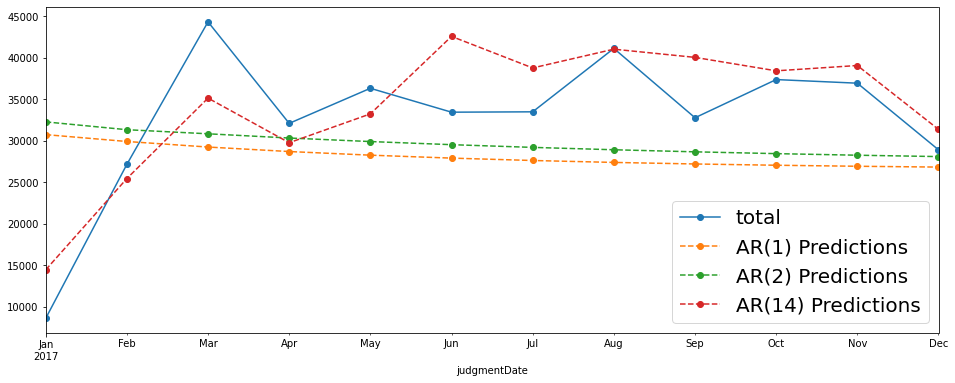

In [98]:
from statsmodels.tsa.ar_model import AR,ARResults

#precisa criar uma instancia para cada metodo a ser realizado o fit 
modelArima = AR(arTrain[field])
modelArima2 = AR(arTrain[field])
modelArima3 = AR(arTrain[field])

AR1fit = modelArima.fit(maxlag=1,method='cmle')
AR2fit = modelArima2.fit(maxlag=2,method='cmle')
AR3fit = modelArima3.fit(maxlag=14,method='cmle')

start=len(arTrain)
end=len(arTrain)+len(arTest)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')
rename = f'AR({AR3fit.k_ar}) Predictions'
predictions11 = AR3fit.predict(start=start,end=end,dynamic=False).rename( f'AR({AR3fit.k_ar}) Predictions')

arTest[field].plot(marker='o',legend=True)
predictions1.plot(style='--', marker='o',legend=True)
predictions2.plot(style='--', marker='o',legend=True)
predictions11.plot(style='--', marker='o',legend=True,figsize=(16,6));

from sklearn.metrics import mean_squared_error
labelsAR = ['AR(1)','AR(2)',f'AR({AR3fit.k_ar})']
ArimaPreds = [predictions1, predictions2, predictions11]  # these are variables, not strings!
ArimaPredsResult = []

for i in range(3):
    print(labelsAR[i],':',forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])
    ArimaPredsResult.append(forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])

In [99]:
dfARIMACompareResult= arTest[[field]].join(pd.DataFrame(predictions1)).join(pd.DataFrame(predictions2)).join(pd.DataFrame(predictions11))
dfARIMACompareResult.columns = [field,'AR','AR1','AR14']
dfARIMACompareResult[field+'_Ant'] = np.where((dfARIMACompareResult[field] > dfARIMACompareResult[field].shift()),"+","-")
dfARIMACompareResult['AR_Ant'] = np.where((dfARIMACompareResult['AR'] > dfARIMACompareResult['AR'].shift()),"+","-")
dfARIMACompareResult['AR1_Ant'] = np.where((dfARIMACompareResult['AR1'] > dfARIMACompareResult['AR1'].shift()),"+","-")
dfARIMACompareResult['AR14_Ant'] = np.where((dfARIMACompareResult['AR14'] > dfARIMACompareResult['AR14'].shift()),"+","-")
dfARIMACompareResult

total            AR           AR1          AR14 total_Ant  \
judgmentDate                                                              
2017-01-01     8625  30765.138283  32300.603364  14474.178099         -   
2017-02-01    27182  29938.278111  31358.710240  25473.303646         +   
2017-03-01    44352  29269.207403  30864.955077  35164.059266         +   
2017-04-01    32122  28727.815244  30356.358164  29789.771026         -   
2017-05-01    36348  28289.736779  29930.728145  33263.944931         +   
2017-06-01    33469  27935.256687  29554.859661  42601.866615         -   
2017-07-01    33513  27648.421919  29227.782318  38798.922651         +   
2017-08-01    41151  27416.323738  28942.030605  41060.213526         +   
2017-09-01    32798  27228.516778  28692.651366  40072.849013         -   
2017-10-01    37399  27076.548961  28474.951537  38452.613337         +   
2017-11-01    36963  26953.581114  28284.921747  39093.204638         -   
2017-12-01    28936  26854.079183  28119.041551  31394.962614         -   

             AR_Ant AR1_Ant AR14_Ant  
judgmentDate                          
2017-01-01        -       -        -  
2017-02-01        -       -        +  
2017-03-01        -       -        +  
2017-04-01        -       -        -  
2017-05-01        -       -        +  
2017-06-01        -       -        +  
2017-07-01        -       -        -  
2017-08-01        -       -        +  
2017-09-01        -       -        -  
2017-10-01        -       -        -  
2017-11-01        -       -        +  
2017-12-01        -       -        -

# CMLE foi melhor do que MLE

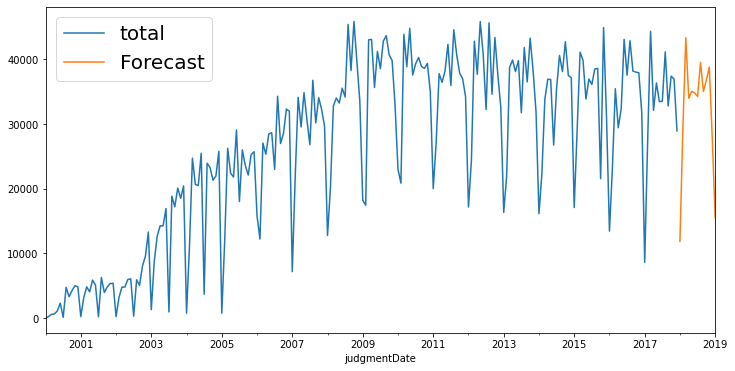

In [100]:
modelARForecast = AR(dfChoosedAR[field])
ARfitForecast = modelARForecast.fit(maxlag=AR3fit.k_ar,method='cmle')
# Make predictions
fcastAR = ARfitForecast.predict(start=len(dfChoosedAR), end=len(dfChoosedAR)+predictFieldPeriod, dynamic=False).rename('Forecast')
dfChoosedAR[field].plot(legend=True)
fcastAR.plot(legend=True,figsize=(12,6));

# ANALISE ARIMA

### ARIMA com AUTO.ARIMA

<!--<hr>
<h1 style="color:red"> VERIFICAR RETORNO DO MODELO </h1>
<hr>-->

### RETORNOU PARA USO SARIMAX (3, 1, 3)x(2, 0, [], 12)	

In [101]:
print(test)

              total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2017-01-01     8625            1879                   1504   
2017-02-01    27182            5425                   4793   
2017-03-01    44352            8927                   7773   
2017-04-01    32122            6805                   5351   
2017-05-01    36348            8146                   6397   
2017-06-01    33469            6918                   5602   
2017-07-01    33513            7446                   6416   
2017-08-01    41151            9180                   7284   
2017-09-01    32798            6915                   6131   
2017-10-01    37399            8114                   6538   
2017-11-01    36963            7559                   6124   
2017-12-01    28936            6542                   5841   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                        

## Sem identificar periodo

(3, 1, 3) (0, 0, 0, 0)


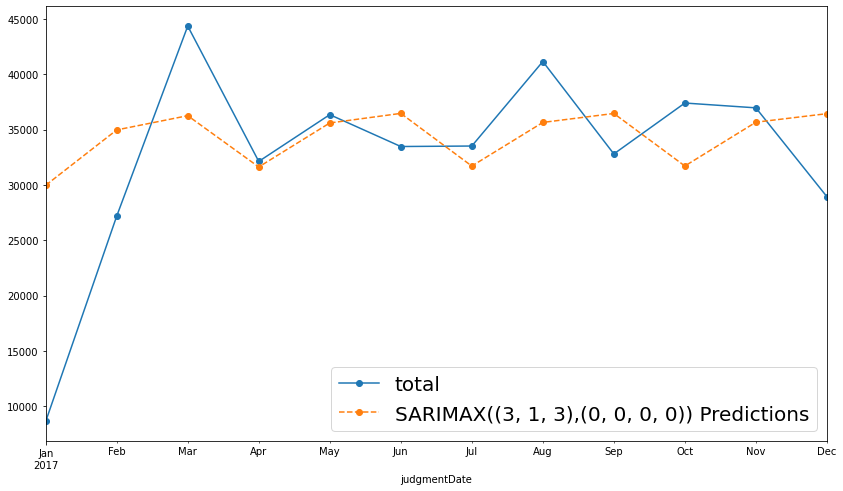

SARIMAX:                                 7792.2318855165395


In [102]:
#para testes sem estacionar a série, utilizar stationary=True
ARIMAauto_arimaNoDiff = auto_arima(train[field],seasonal=True,stationary=False) 

print(ARIMAauto_arimaNoDiff.order,ARIMAauto_arimaNoDiff.seasonal_order)

modelARMANoDiff = SARIMAX(train[field],order=ARIMAauto_arimaNoDiff.order,seasonal_order=ARIMAauto_arimaNoDiff.seasonal_order)
resultARMANoDiff = modelARMANoDiff.fit()
predictionsARMANodiff = resultARMANoDiff.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoDiff.order},{ARIMAauto_arimaNoDiff.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8),marker='o')
predictionsARMANodiff.plot(legend=True,style='--', marker='o')
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANodiff)['rmse'])

(3, 1, 3) (2, 0, 0, 12)


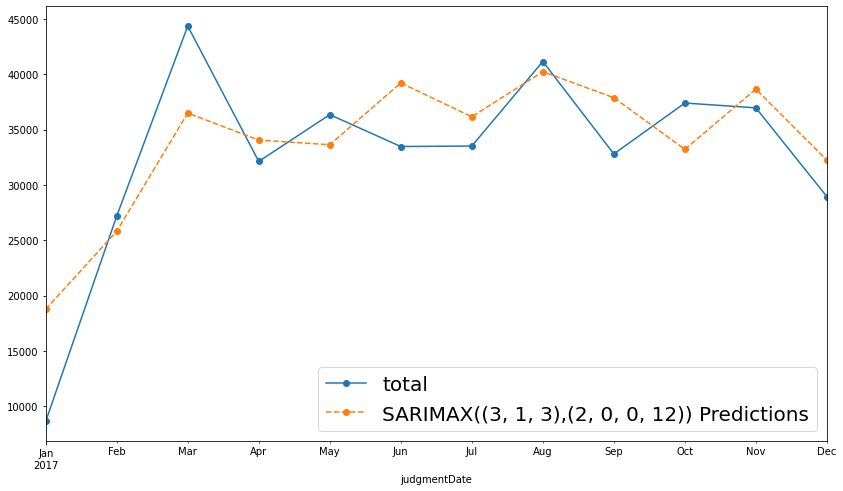

SARIMAX:                                 4790.366029949612


In [103]:
ARIMAauto_arimaNoDiff = auto_arima(train[field],seasonal=True,stationary=False,m=predictFieldPeriod) 
ARIMAauto_arimaNoDiff

print(ARIMAauto_arimaNoDiff.order,ARIMAauto_arimaNoDiff.seasonal_order)

modelARMANoDiff = SARIMAX(train[field],order=ARIMAauto_arimaNoDiff.order,seasonal_order=ARIMAauto_arimaNoDiff.seasonal_order,m=predictFieldPeriod)
resultARMANoDiff = modelARMANoDiff.fit()
predictionsARMANodiff = resultARMANoDiff.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoDiff.order},{ARIMAauto_arimaNoDiff.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8),marker='o')
predictionsARMANodiff.plot(style='--', marker='o',legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANodiff)['rmse'])

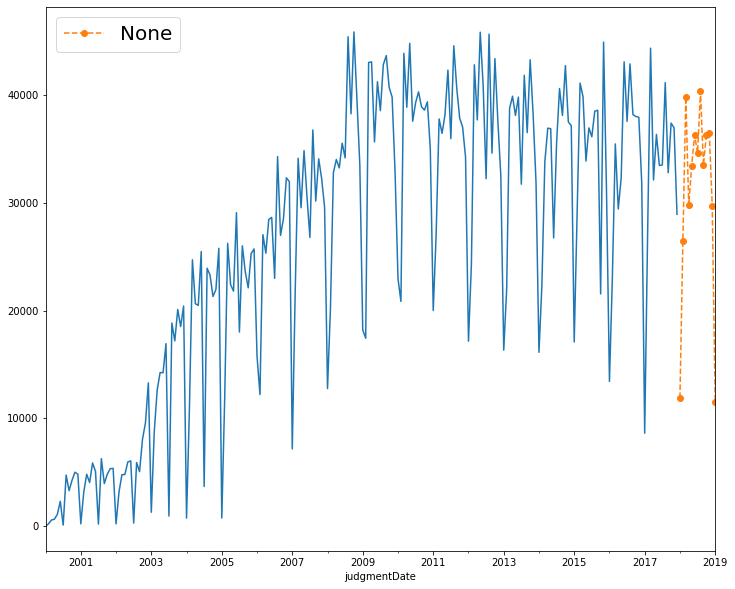

In [104]:
#prevendo sobre o dataset
modelARMANoDiff = SARIMAX(dfChoosed[[field]],order=ARIMAauto_arimaNoDiff.order,seasonal_order=ARIMAauto_arimaNoDiff.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoDiff = modelARMANoDiff.fit()
fcastARIMANoDiff = resultsForeCastARIMANoDiff.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMANoDiff.plot(style='--', marker='o',legend=True)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


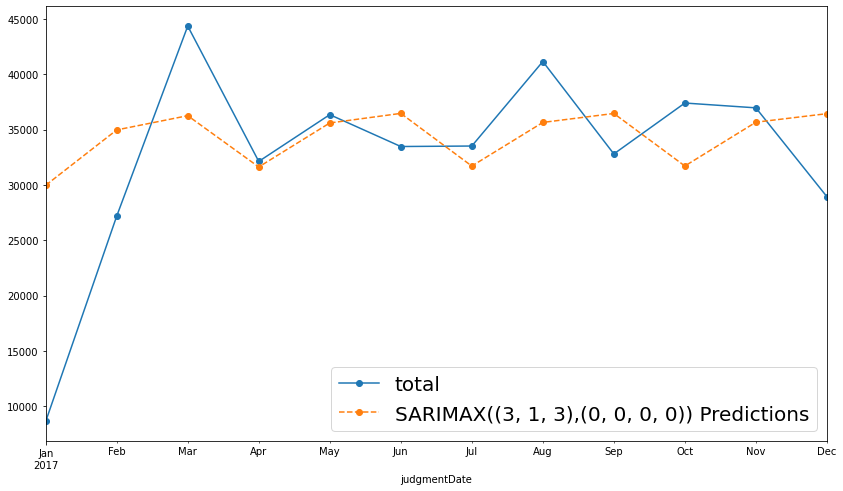

12 12
SARIMAX:                                 7792.2318855165395


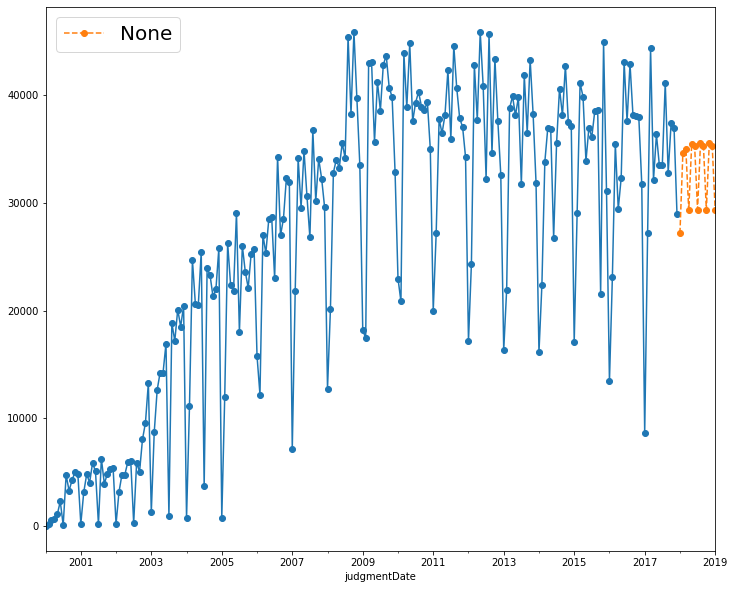

In [105]:
ARIMAauto_arimaNoSeas = auto_arima(train[field])
print(ARIMAauto_arimaNoSeas)

modelARMANoDiffNoSeas = SARIMAX(train[field],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order)
resultARMANoSeas = modelARMANoDiffNoSeas.fit()

start=len(train)
end=len(train)+len(test) - 1

predictionsARMANoSeas = resultARMANoSeas.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoSeas.order},{ARIMAauto_arimaNoSeas.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8),marker='o')
predictionsARMANoSeas.plot(legend=True,style='--', marker='o')
ax.autoscale(axis='x',tight=True)
plt.show()
print(len(test[field]),len(predictionsARMANoSeas))
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANoSeas)['rmse'])

#prevendo sobre o dataset
modelARMANoSeas = SARIMAX(dfChoosed[[field]],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoSeas = modelARMANoSeas.fit()
fcastARIMANoSeas = resultsForeCastARIMANoSeas.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10),marker='o')
fcastARIMANoSeas.plot(legend=True,style='--', marker='o')

In [106]:
#teste seasonal decompose
dfTesteSeasonalDecompose = seasonal_decompose(train[field][-360:],model='mul',extrapolate_trend='freq').seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['2'] = seasonal_decompose(train[field][-360:],model='mul',extrapolate_trend=12).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['3'] = seasonal_decompose(train[field][-360:],model='mul',extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['4'] = seasonal_decompose(train[field][-360:],model='mul',two_sided=True,extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['5'] = seasonal_decompose(train[field][-360:],model='mul',two_sided=False,extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose.head(4)

seasonal         2         3         4         5
judgmentDate                                                  
2015-11-01    1.181436  1.182336  1.184319  1.184319  1.182141
2015-12-01    1.106748  1.107585  1.109498  1.109498  1.127806
2016-01-01    0.338432  0.338474  0.339090  0.339090  0.324485
2016-02-01    0.658869  0.658385  0.657768  0.657768  0.685271

# APLICANDO EXOGENOUS DATA 

### Teoria: ARMA

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data = train.copy()
result_mul = seasonal_decompose(data[field],model='mul',extrapolate_trend='freq',two_sided=True) 

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index.head(2)

#merge with the base data
data['month'] = data.index.month
dfSeasonalDiff = pd.merge(data, seasonal_index, how='left', on='month')
dfSeasonalDiff.index = data.index
display(dfSeasonalDiff.tail(3))

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2016-10-01    38016            7600                   6484   
2016-11-01    37940            8076                   6499   
2016-12-01    31787            6773                   5493   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2016-10-01                      4003           4378    1907            2899   
2016-11-01                      4745           3848    1739            2405   
2016-12-01                      4090           3838    1434            2185   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2016-10-01             1326                           1025   
2016-11-01             1220                            714   
2016-12-01             1153                            965   

              Reexame Necessário  ...  Crimes contra a honra  \
judgmentDate                      ...                          
2016-10-01                   503  ...                      0   
2016-11-01                   266  ...                      0   
2016-12-01                   444  ...                      0   

              Incidente de Inconstitucionalidade  \
judgmentDate                                       
2016-10-01                                     4   
2016-11-01                                     1   
2016-12-01                                     2   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2016-10-01                                      0   
2016-11-01                                      0   
2016-12-01                                      1   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2016-10-01                               1                   0       95   
2016-11-01                               0                   0       87   
2016-12-01                               2                   0       96   

              weekType  Feriado  month  seasonal  
judgmentDate                                      
2016-10-01          21       30     10  1.156128  
2016-11-01          22       28     11  1.181436  
2016-12-01          22       28     12  1.106748  

[3 rows x 52 columns]

In [108]:
ARIMAauto_arimaExog = auto_arima(train[[field]],seasonal=True,m=12,exogenous=dfSeasonalDiff[['seasonal']])
ARIMAauto_arimaExog

modelARMAExog = SARIMAX(train[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order)
resultARMAExog = modelARMAExog.fit()
#resultARMAExog.summary()

start=len(train)
end=len(train)+len(test)-1

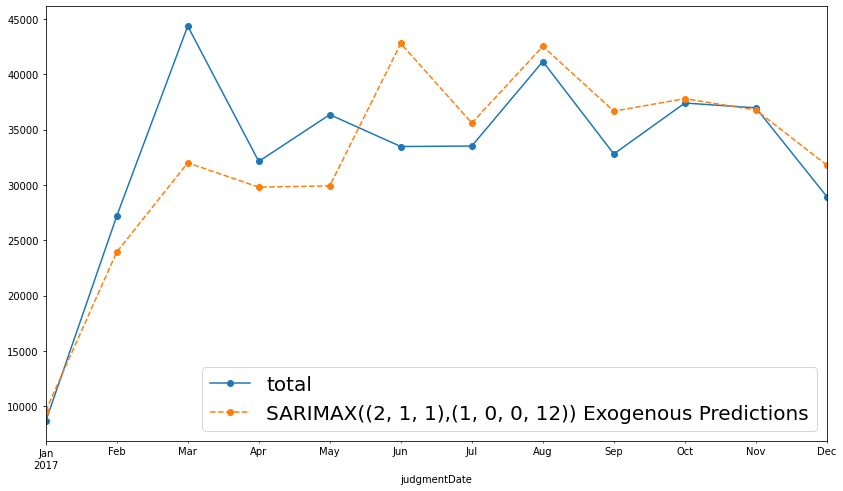

SARIMAX:                                 5220.704844848421


In [109]:
predictionsARMAExog = resultARMAExog.predict(start=start, end=end,exogenous=np.tile(dfSeasonalDiff['seasonal'].values, 2)).rename(f'SARIMAX({ARIMAauto_arimaExog.order},{ARIMAauto_arimaExog.seasonal_order}) Exogenous Predictions')
ax = test[field].plot(legend=True,figsize=(14,8),marker='o')
predictionsARMAExog.plot(legend=True,style='--', marker='o')
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMAExog)['rmse'])

### Predição futura

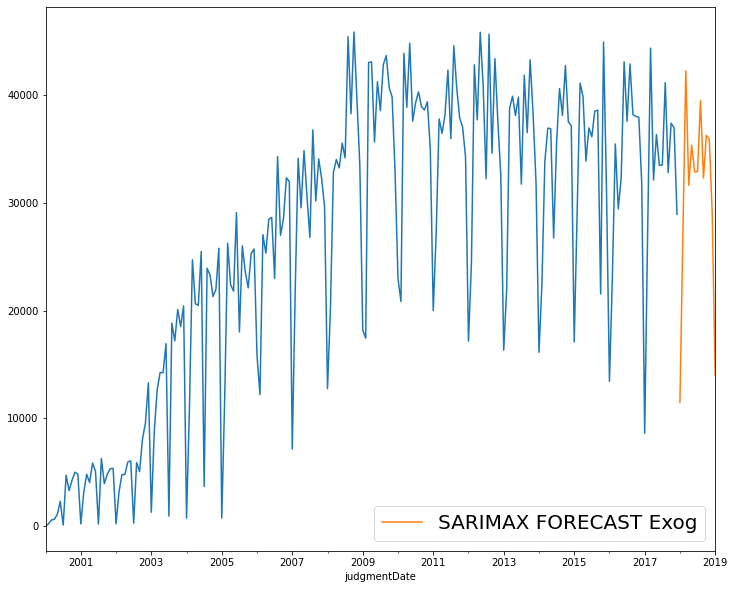

In [110]:
modelARIMAExog = SARIMAX(dfChoosed[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMAExog = modelARIMAExog.fit()
fcastARIMAExog = resultsForeCastARIMAExog.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMAExog.rename('SARIMAX FORECAST Exog').plot(legend=True);

#4782

<div class="alert alert-info"><h1> VAR - VECTOR AUTO REGRESSION
</h1>
    <hr/>    
</div>

In [111]:
#eliminar duplicidade para analise
uniqueTypesComparison = []
for i in dfUniqueTypes:
    for i1 in dfUniqueTypes:
        if i != i1:
            if {i1,i} not in uniqueTypesComparison:
                uniqueTypesComparison.append({i,i1})
            

print(len(dfUniqueTypes),len(uniqueTypesComparison))

119 7021


In [112]:
dfVAR = dfChoosed[VARFields[:]]
dfVAR['month'] = dfVAR.index.month
dfVAR

Apelação Cível  Agravo de Instrumento  Embargos de Declaração  \
judgmentDate                                                                  
2000-01-01                 0                     10                       0   
2000-02-01               151                     35                       2   
2000-03-01               277                     93                      30   
2000-04-01               343                    145                      19   
2000-05-01               595                    318                      78   
...                      ...                    ...                     ...   
2017-08-01              9180                   7284                    5763   
2017-09-01              6915                   6131                    3648   
2017-10-01              8114                   6538                    4982   
2017-11-01              7559                   6124                    4459   
2017-12-01              6542                   5841                    3958   

              Recurso Cível  Agravo  Apelação Crime  Habeas Corpus  \
judgmentDate                                                         
2000-01-01                0       0               0              0   
2000-02-01                0       4               1              0   
2000-03-01                0      17               5              0   
2000-04-01                0      18               3              2   
2000-05-01                0      11               7              3   
...                     ...     ...             ...            ...   
2017-08-01             4238    1977            2912           1440   
2017-09-01             3040    1700            2465           1423   
2017-10-01             4923    1382            2406           1103   
2017-11-01             4339    1905            2885           1274   
2017-12-01             2525    1527            2519           1149   

              Apelação e Reexame Necessário  Reexame Necessário  \
judgmentDate                                                      
2000-01-01                                0                   0   
2000-02-01                               25                   1   
2000-03-01                              118                  21   
2000-04-01                               89                  14   
2000-05-01                               53                  16   
...                                     ...                 ...   
2017-08-01                              843                 295   
2017-09-01                              741                 229   
2017-10-01                              679                 366   
2017-11-01                              545                 197   
2017-12-01                              511                 185   

              Recurso Crime  month  
judgmentDate                        
2000-01-01                0      1  
2000-02-01                0      2  
2000-03-01                0      3  
2000-04-01                0      4  
2000-05-01                0      5  
...                     ...    ...  
2017-08-01              287      8  
2017-09-01              431      9  
2017-10-01              319     10  
2017-11-01              403     11  
2017-12-01              203     12  

[216 rows x 11 columns]

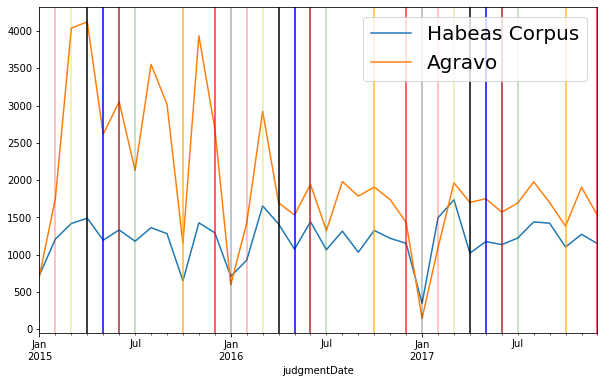

In [113]:
dfAnalise = dfVAR[['Habeas Corpus','Agravo','month']]['2015':]
ax = dfAnalise[['Habeas Corpus','Agravo']].plot(figsize=(10,6))
ax.autoscale(axis='x',tight=True)
for x in dfAnalise.query('month==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);
for x in dfAnalise.query('month==2').index: 
    ax.axvline(x=x, color='r', alpha = 0.3);
for x in dfAnalise.query('month==3').index: 
    ax.axvline(x=x, color='y', alpha = 0.3);
for x in dfAnalise.query('month==4').index: 
    ax.axvline(x=x, color='black', alpha = 1);
for x in dfAnalise.query('month==5').index: 
    ax.axvline(x=x, color='blue', alpha = 1);
for x in dfAnalise.query('month==6').index: 
    ax.axvline(x=x, color='brown', alpha = 1);
for x in dfAnalise.query('month==7').index:     
    ax.axvline(x=x, color='g', alpha = 0.3);
for x in dfAnalise.query('month==10').index:     
    ax.axvline(x=x, color='orange', alpha = 0.8);
for x in dfAnalise.query('month==12').index:     
    ax.axvline(x=x, color='red', alpha = 0.8);

Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data 

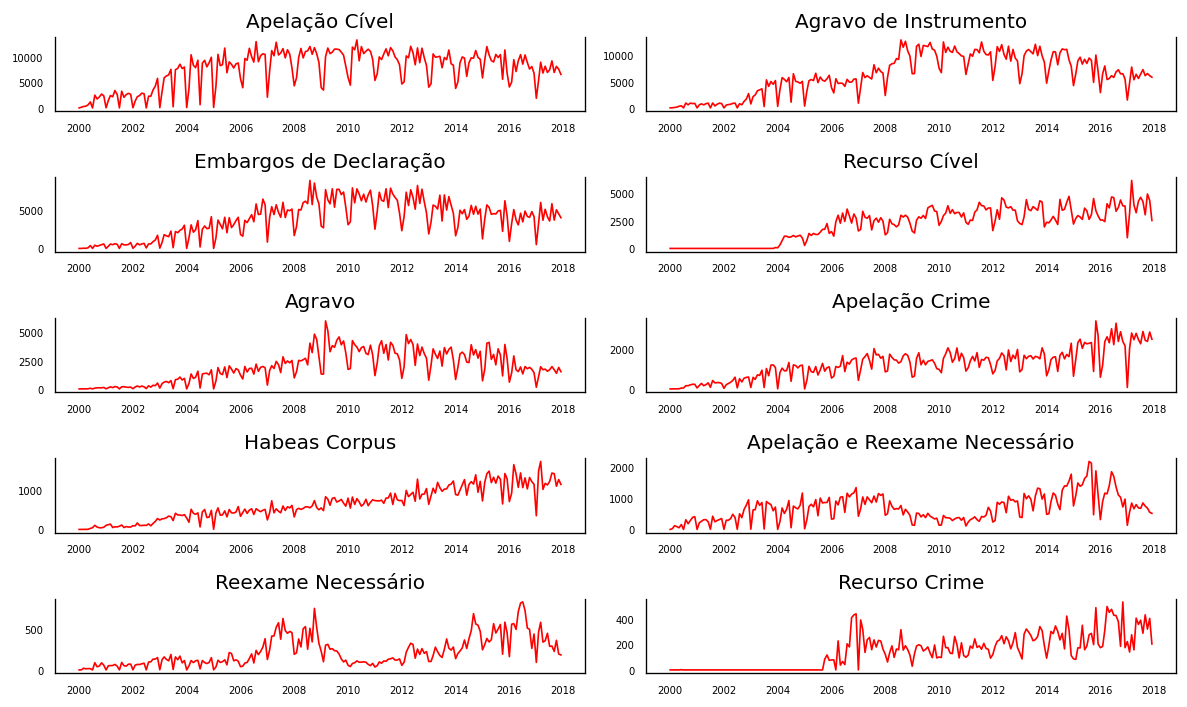

In [114]:
#checar se todos os componentes do VAR são estacionarios 
if 'month' in dfVAR.columns:
    del dfVAR['month']

dfVARDiff = dfVAR.copy()
hasOne = False

for coluna in dfVARDiff.columns:
    while(adf_teste(dfVARDiff[coluna])[0] >= 0.05):
        dfVARDiff = dfVARDiff.diff().dropna()
        break;

#print(len(dfVAR),len(dfVARDiff.dropna()))        
    
#testa novamente
for coluna in dfVARDiff.columns:
    print(adf_teste(dfVARDiff[coluna])[7])
    
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):    
    data = dfVAR[dfVAR.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dfVAR.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout();

In [115]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
testarrr = ''
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):       
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:              
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

dfCorrelationGrangerMatrixNonStationary = grangers_causation_matrix(dfVAR, variables = dfVAR.columns) 

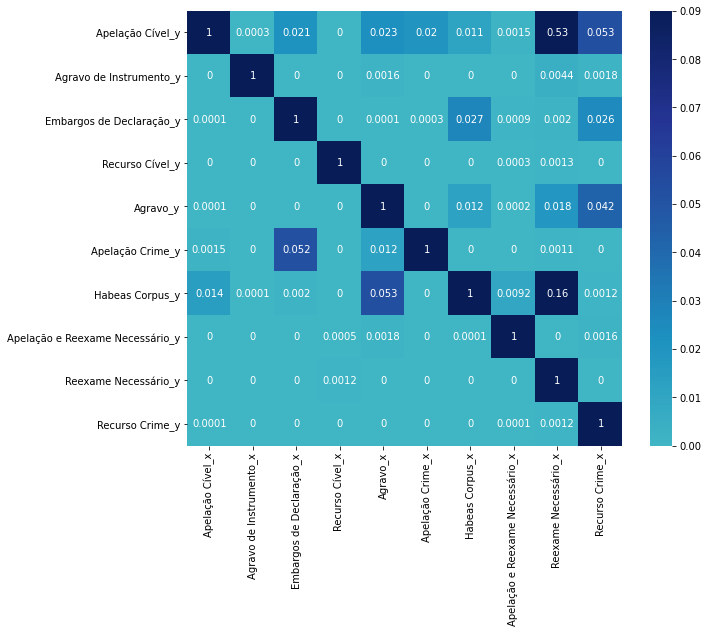

In [116]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dfCorrelationGrangerMatrixNonStationary, 
            xticklabels=dfCorrelationGrangerMatrixNonStationary.columns.values,
            yticklabels=dfCorrelationGrangerMatrixNonStationary.index.values,center=0,vmax=.09,square=True,cmap="YlGnBu",annot=True) 

In [117]:
import plotly.graph_objects as go

fig = go.Figure()

for i in dfVAR.columns:
    fig.add_trace(go.Scatter(x=dfVAR.reset_index()['judgmentDate'], y=dfVAR[i],
                    mode='lines',
                    name=i))
fig.show()

In [118]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)


def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col,35), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dfVAR)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Apelação Cível                      ::  286.32    > 219.4051  =>   True
Agravo de Instrumento               ::  212.4     > 179.5199  =>   True
Embargos de Declaração              ::  151.91    > 143.6691  =>   True
Recurso Cível                       ::  94.86     > 111.7797  =>   False
Agravo                              ::  63.02     > 83.9383   =>   False
Apelação Crime                      ::  36.58     > 60.0627   =>   False
Habeas Corpus                       ::  22.87     > 40.1749   =>   False
Apelação e Reexame Necessário       ::  9.71      > 24.2761   =>   False
Reexame Necessário                  ::  4.13      > 12.3212   =>   False
Recurso Crime                       ::  0.2       > 4.1296    =>   False


In [119]:
import statsmodels.tsa.stattools as ts
uniqueTypesVARComparison = []
dataVARRes = []
for i in dfVAR.columns:
    for i1 in dfVAR.columns:
        if i != i1:
            if {i1,i} not in uniqueTypesVARComparison:
                coin_result = ts.coint(dfVAR[i], dfVAR[i1]) 
                uniqueTypesVARComparison.append({i1,i})
                dataVARRes.append({'i':i,'i1':i1,'coin_result':coin_result[1]})

dfVARResultTest = pd.DataFrame(dataVARRes)                
display(dfVARResultTest.sort_values(by='coin_result',ascending=True).head(10))
    

i                      i1  coin_result
44             Reexame Necessário           Recurso Crime     0.176926
38                 Apelação Crime           Recurso Crime     0.232223
11          Agravo de Instrumento                  Agravo     0.250139
10          Agravo de Instrumento           Recurso Cível     0.275284
18         Embargos de Declaração                  Agravo     0.286345
41                  Habeas Corpus           Recurso Crime     0.292827
43  Apelação e Reexame Necessário           Recurso Crime     0.309495
29                  Recurso Cível           Recurso Crime     0.399450
42  Apelação e Reexame Necessário      Reexame Necessário     0.415132
9           Agravo de Instrumento  Embargos de Declaração     0.420603

In [120]:
nobs = sazonalPeriod
dfVAR_train, dfVAR_test = dfVAR[0:-nobs], dfVAR[-nobs:]
dfVAR_test

Apelação Cível  Agravo de Instrumento  Embargos de Declaração  \
judgmentDate                                                                  
2017-01-01              1879                   1504                     489   
2017-02-01              5425                   4793                    3275   
2017-03-01              8927                   7773                    5931   
2017-04-01              6805                   5351                    3630   
2017-05-01              8146                   6397                    5045   
2017-06-01              6918                   5602                    4077   
2017-07-01              7446                   6416                    3528   
2017-08-01              9180                   7284                    5763   
2017-09-01              6915                   6131                    3648   
2017-10-01              8114                   6538                    4982   
2017-11-01              7559                   6124                    4459   
2017-12-01              6542                   5841                    3958   

              Recurso Cível  Agravo  Apelação Crime  Habeas Corpus  \
judgmentDate                                                         
2017-01-01              968     147              74            350   
2017-02-01             3194    1095            2064           1496   
2017-03-01             6150    1964            2833           1737   
2017-04-01             3920    1701            2493           1022   
2017-05-01             3229    1751            2817           1177   
2017-06-01             4266    1571            2505           1136   
2017-07-01             4621    1693            2287           1224   
2017-08-01             4238    1977            2912           1440   
2017-09-01             3040    1700            2465           1423   
2017-10-01             4923    1382            2406           1103   
2017-11-01             4339    1905            2885           1274   
2017-12-01             2525    1527            2519           1149   

              Apelação e Reexame Necessário  Reexame Necessário  Recurso Crime  
judgmentDate                                                                    
2017-01-01                              131                  93            222  
2017-02-01                              554                 471            140  
2017-03-01                              839                 589            275  
2017-04-01                              658                 344            157  
2017-05-01                              790                 360            405  
2017-06-01                              685                 453            356  
2017-07-01                              669                 292            389  
2017-08-01                              843                 295            287  
2017-09-01                              741                 229            431  
2017-10-01                              679                 366            319  
2017-11-01                              545                 197            403  
2017-12-01                              511                 185            203

In [121]:
dfVARDifference = dfVAR.copy()
tt=0
for coluna in dfVARDifference.columns:
    while(adf_teste(dfVARDifference[coluna])[0] >= 0.05):
        dfVARDifference = dfVARDifference.diff().dropna()
        tt=tt+1
        break;

print(tt)
        
for coluna in dfVARDifference.columns:
     if adf_teste(dfVARDifference[coluna])[0] >= 0.05:
        print('erro')       

2


In [122]:
model = VAR(dfVARDifference)
for i in [1,2,3,4,5,6,7,8,9]:
    try:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        print('erro, \n')
        continue

model.select_order(9).summary()

Lag Order = 1
AIC :  122.53953721458149
BIC :  124.2754157978117
FPE :  1.654414187100315e+53
HQIC:  123.24106352809581 

Lag Order = 2
AIC :  120.26567155045511
BIC :  123.59059191687551
FPE :  1.712175688914468e+52
HQIC:  121.6095266962767 

Lag Order = 3
AIC :  118.96731850234433
BIC :  123.89184940934707
FPE :  4.7440864603060394e+51
HQIC:  120.9579117036309 

Lag Order = 4
AIC :  118.50339065792457
BIC :  125.03821964646819
FPE :  3.0720074872964385e+51
HQIC:  121.14517984038868 

Lag Order = 5
AIC :  117.32943572339168
BIC :  125.48537097938237
FPE :  9.98081029045012e+50
HQIC:  120.62692824474324 

Lag Order = 6
AIC :  116.9475317694196
BIC :  126.73550402238982
FPE :  7.357207408624843e+50
HQIC:  120.9052851623882 

Lag Order = 7
AIC :  116.37977560270011
BIC :  127.81084006269244
FPE :  4.665895843453309e+50
HQIC:  121.00239833193305 

Lag Order = 8
AIC :  115.91767777708296
BIC :  129.00301611067306
FPE :  3.4419227082162964e+50
HQIC:  121.20983001022185 

Lag Order = 9
AIC :

<class 'statsmodels.iolib.table.SimpleTable'>

In [123]:
model_fitted = model.fit(9)
#model_fitted.summary()

In [124]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dfVARDifference.columns, out):
    detail = ""
    if  round(val, 2) > 2:
        detail = "Negative Serial Correlation"
    else:
        detail = "Positive Serial Correlation"
    print((adjust(col)+':').ljust(30, ' '), round(val, 2), ' ' + detail)

Apelação Cível:                2.04  Negative Serial Correlation
Agravo de Instrumento:         2.03  Negative Serial Correlation
Embargos de Declaração:        1.97  Positive Serial Correlation
Recurso Cível:                 2.09  Negative Serial Correlation
Agravo:                        1.92  Positive Serial Correlation
Apelação Crime:                1.87  Positive Serial Correlation
Habeas Corpus:                 1.94  Positive Serial Correlation
Apelação e Reexame Necessário: 2.16  Negative Serial Correlation
Reexame Necessário:            2.04  Negative Serial Correlation
Recurso Crime:                 2.03  Negative Serial Correlation


In [125]:
lag_order = model_fitted.k_ar
# Input data for forecasting
forecast_input = dfVARDifference.values[-lag_order:]

In [126]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
print(dfVAR.shape,fc.shape)
df_forecast = pd.DataFrame(fc, index=dfVAR.index[-nobs:], columns=dfVARDifference.columns + '_2d')
#df_forecast

(216, 10) (12, 10)


In [127]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = dfVARDifference.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [128]:
df_results = invert_transformation(dfVAR_train, df_forecast, second_diff=True) 

colunas =[]
for i in df_results.columns:
    if 'forecast' in i:
        colunas.append(i)
print(colunas)

df_results.loc[:, colunas]

['Apelação Cível_forecast', 'Agravo de Instrumento_forecast', 'Embargos de Declaração_forecast', 'Recurso Cível_forecast', 'Agravo_forecast', 'Apelação Crime_forecast', 'Habeas Corpus_forecast', 'Apelação e Reexame Necessário_forecast', 'Reexame Necessário_forecast', 'Recurso Crime_forecast']


Apelação Cível_forecast  Agravo de Instrumento_forecast  \
judgmentDate                                                            
2017-01-01                1991.261911                      352.529797   
2017-02-01                4812.100043                     2444.756290   
2017-03-01                5524.449150                     1813.213047   
2017-04-01                3353.985256                    -1240.383643   
2017-05-01                4026.373365                     -201.332031   
2017-06-01                3732.105923                    -1712.191119   
2017-07-01                 744.271718                    -3760.456653   
2017-08-01                4299.361197                    -1517.667179   
2017-09-01                1909.148029                    -5374.273732   
2017-10-01                2373.703818                    -4966.877774   
2017-11-01               -1249.485407                    -7646.679919   
2017-12-01                1714.655954                    -6990.679791   

              Embargos de Declaração_forecast  Recurso Cível_forecast  \
judgmentDate                                                            
2017-01-01                        1762.519766             5527.192663   
2017-02-01                        1579.768173             7564.635869   
2017-03-01                        3299.679442             8686.843106   
2017-04-01                         863.135137            10818.735734   
2017-05-01                        1810.915879            13041.368349   
2017-06-01                        1366.113297            13125.840719   
2017-07-01                         161.687545            15640.592549   
2017-08-01                        1956.837446            17707.729739   
2017-09-01                        -817.682171            18527.514199   
2017-10-01                         353.664820            20280.116746   
2017-11-01                        -914.258922            21944.530149   
2017-12-01                        -515.503983            23368.678903   

              Agravo_forecast  Apelação Crime_forecast  \
judgmentDate                                             
2017-01-01         552.842877              1371.412853   
2017-02-01         110.327865              1739.495136   
2017-03-01        2035.839261              2494.780813   
2017-04-01         593.089572              2540.101966   
2017-05-01        1177.050651              2265.919933   
2017-06-01        1138.924905              2370.930288   
2017-07-01         819.282310              2574.821188   
2017-08-01        1825.504195              3417.971537   
2017-09-01         908.315452              2511.746954   
2017-10-01        1107.649936              2958.298068   
2017-11-01        1125.187912              2807.619430   
2017-12-01        1451.657179              3362.355071   

              Habeas Corpus_forecast  Apelação e Reexame Necessário_forecast  \
judgmentDate                                                                   
2017-01-01               1298.806473                              383.852384   
2017-02-01               1143.596977                             1153.410850   
2017-03-01               1625.885802                             1483.882474   
2017-04-01               1406.089215                             1694.496706   
2017-05-01               1539.786741                             1884.808156   
2017-06-01               1444.395421                             2084.064702   
2017-07-01               1771.265511                             2071.552510   
2017-08-01               1777.429676                             2782.580651   
2017-09-01               1619.531843                             2456.576907   
2017-10-01               1805.069358                             3218.132395   
2017-11-01               1797.731605                             2861.635833   
2017-12-01               2046.860981                             3511.947751   

              Reexame Necessário_f

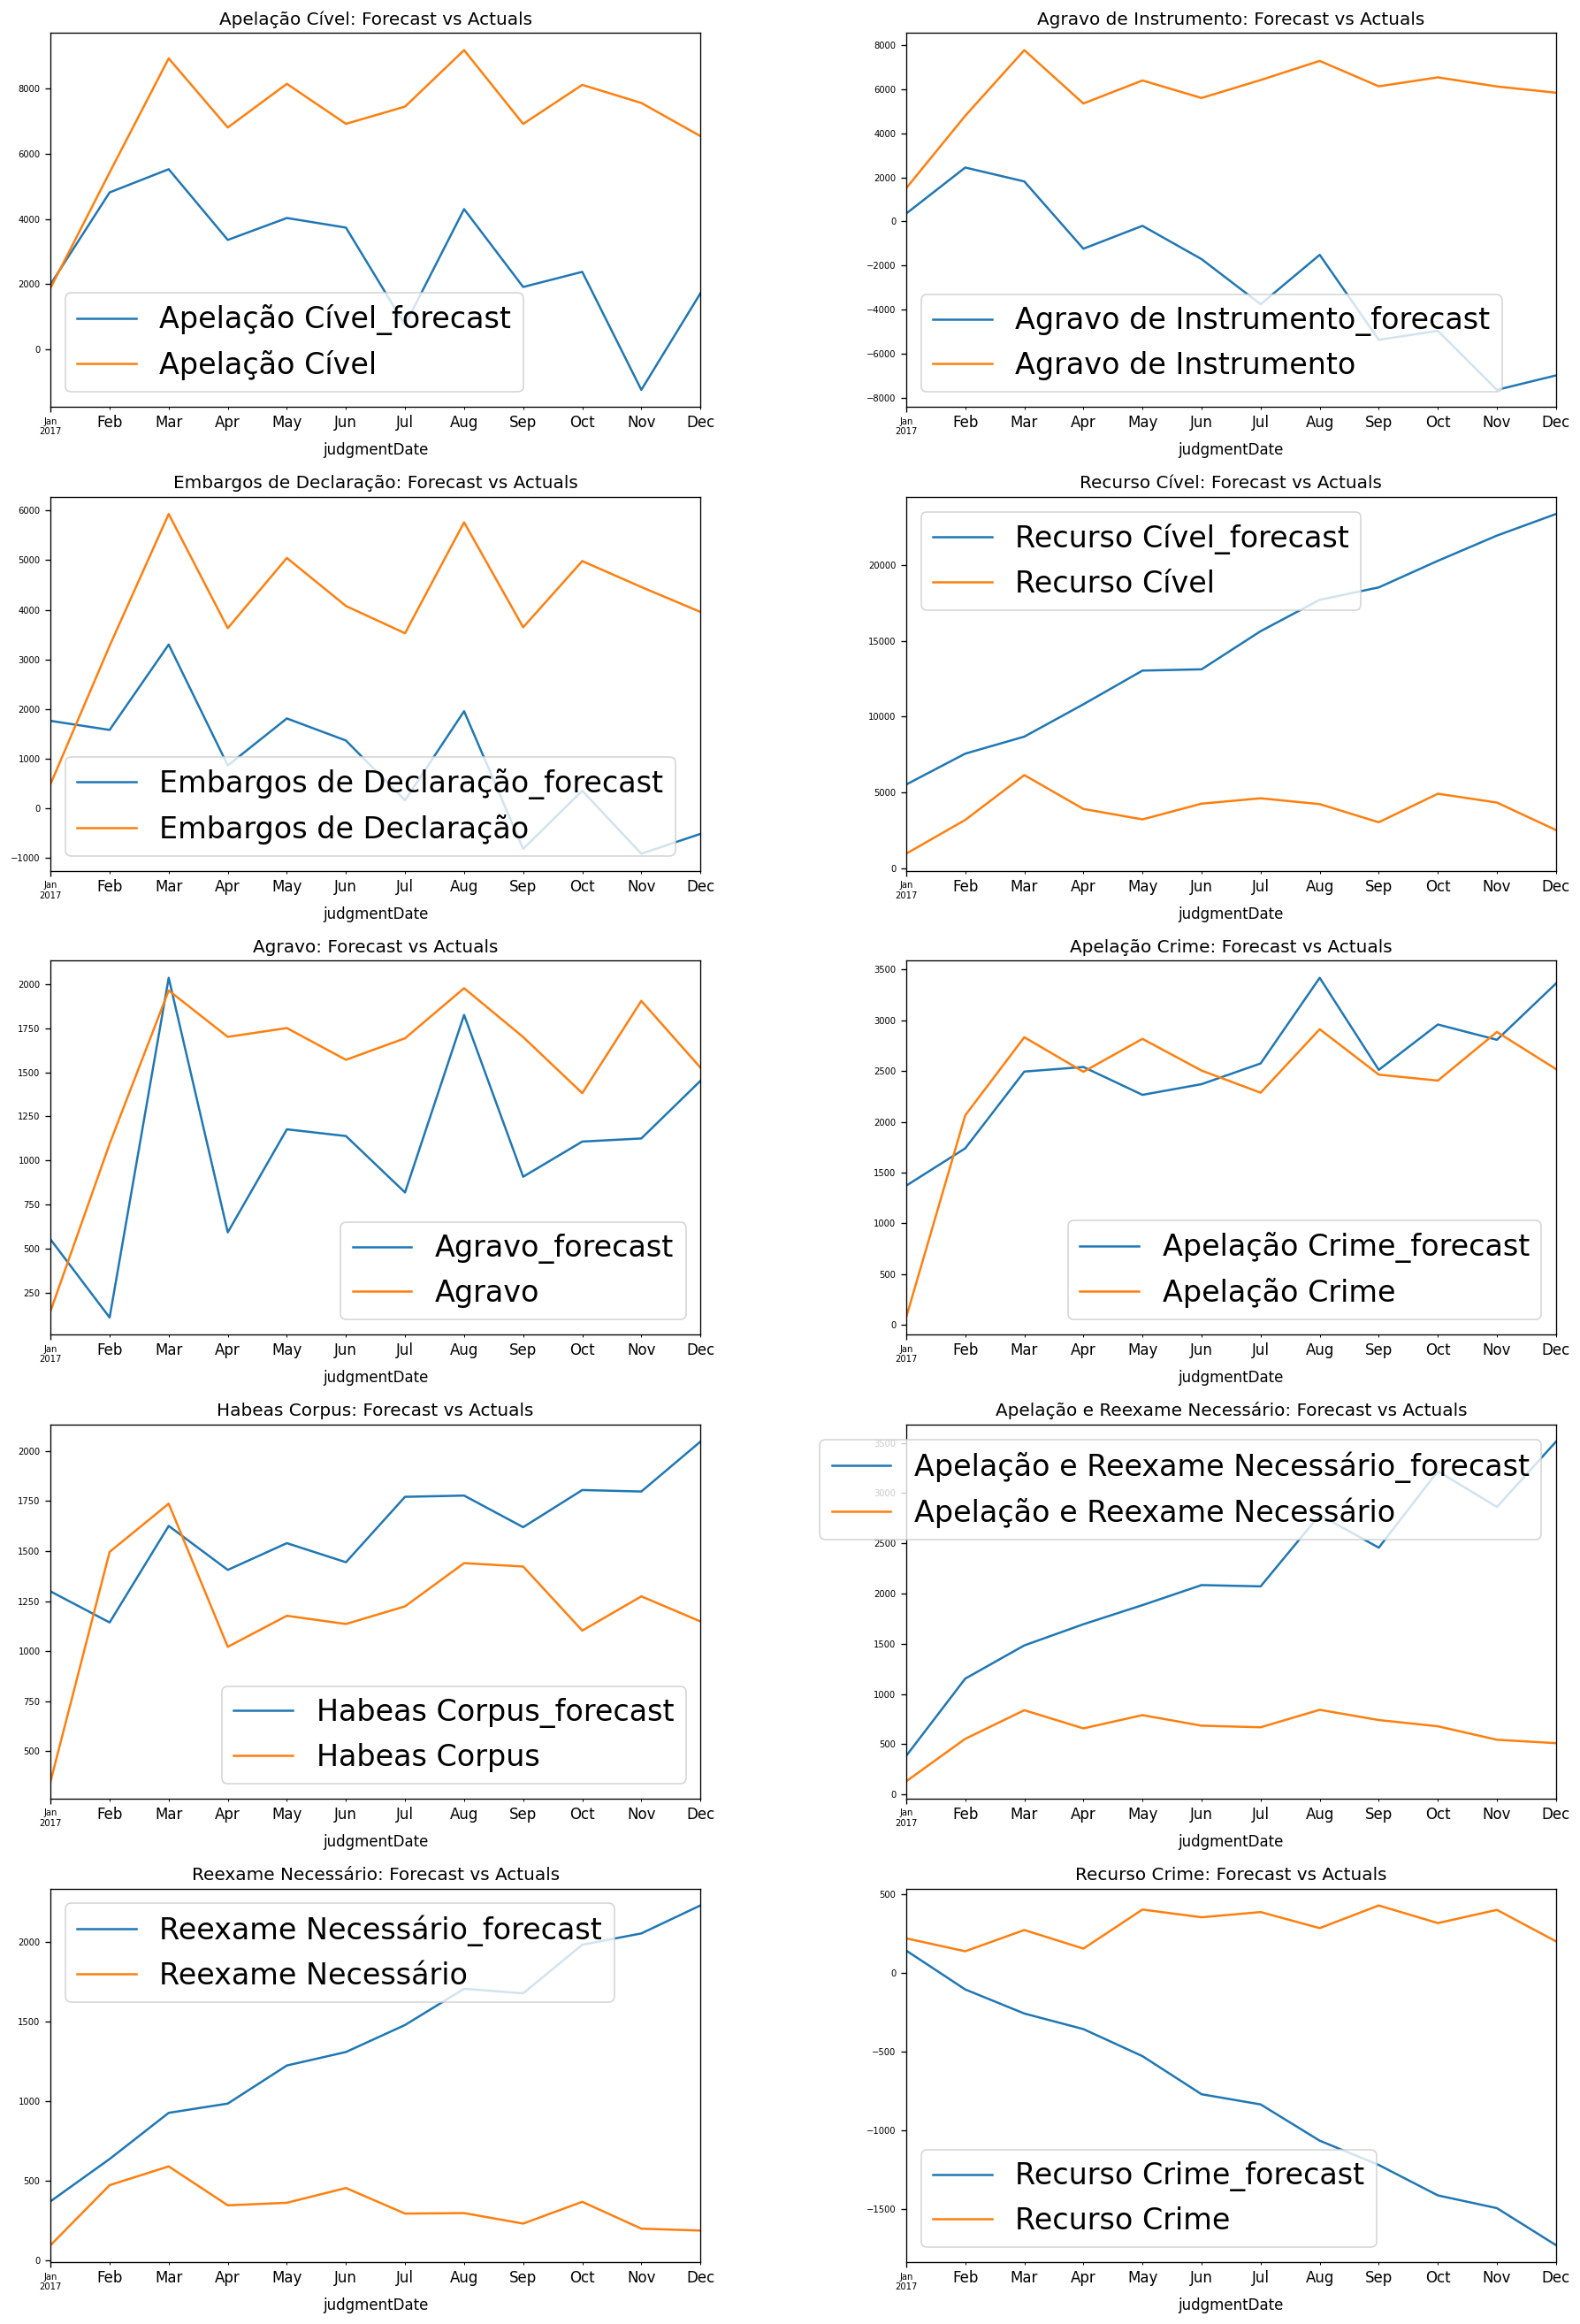

In [129]:
fig, axes = plt.subplots(5, ncols=2, dpi=120,figsize=(15,22))
for i, (col,ax) in enumerate(zip(dfVARDifference.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dfVAR_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    #ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [130]:
for i in colunas:
    print(i)
    itemI = i.replace('_forecast','')
    print(f'Forecast Accuracy of: {itemI}')
    accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR_test[itemI])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))
    print('\n')

Apelação Cível_forecast
Forecast Accuracy of: Apelação Cível
mape   :  0.5661
me     :  -4218.6724
mae    :  4237.3827
mpe    :  -0.5562
rmse   :  4818.6475
corr   :  0.1899
minmax :  0.5658


Agravo de Instrumento_forecast
Forecast Accuracy of: Agravo de Instrumento
mape   :  1.3723
me     :  -8212.8369
mae    :  8212.8369
mpe    :  -1.3723
rmse   :  9050.2656
corr   :  -0.2084
minmax :  1.3723


Embargos de Declaração_forecast
Forecast Accuracy of: Embargos de Declaração
mape   :  0.9781
me     :  -3156.5103
mae    :  3368.7636
mpe    :  -0.544
rmse   :  3570.1324
corr   :  0.1789
minmax :  0.8213


Recurso Cível_forecast
Forecast Accuracy of: Recurso Cível
mape   :  3.288
me     :  10901.7316
mae    :  10901.7316
mpe    :  3.288
rmse   :  12219.1073
corr   :  0.1681
minmax :  0.7094


Agravo_forecast
Forecast Accuracy of: Agravo
mape   :  0.5555
me     :  -463.944
mae    :  543.5577
mpe    :  -0.0893
rmse   :  644.5393
corr   :  0.5984
minmax :  0.3865


Apelação Crime_forecast
Fore

<div class="alert alert-info"><h1> FACEBOOK PROPHET
</h1>
    <hr/>    
</div>


In [131]:
from fbprophet import Prophet

dfProphet = dfChoosed[[field]].copy()

dfProphetTrain = dfProphet[:'2016']
dfProphetTrain = dfProphetTrain.reset_index()
dfProphetTrain.columns = ['ds','y']

dfProphetTest = dfProphet['2017':]
dfProphetTest = dfProphetTest.reset_index()
dfProphetTest.columns = ['ds','y']


dfProphet = dfProphet.reset_index()
dfProphet.columns = ['ds','y']

dfProphetTest.tail(20)

ds      y
0  2017-01-01   8625
1  2017-02-01  27182
2  2017-03-01  44352
3  2017-04-01  32122
4  2017-05-01  36348
5  2017-06-01  33469
6  2017-07-01  33513
7  2017-08-01  41151
8  2017-09-01  32798
9  2017-10-01  37399
10 2017-11-01  36963
11 2017-12-01  28936

# ANALISE PARA INDICAÇOES DE SAZONALIDADE 

In [132]:
import datetime

preNatalPreAnoNovo = []

for year in range(2000,2026):
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-24',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-31',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-09-20',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-09-07',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-11-15',format='%Y-%m-%d'))    
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-02-02',format='%Y-%m-%d')) (apenas porto alegre)
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-05-01',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-11-02',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-04-21',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-10-12',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-10-12',format='%Y-%m-%d'))
    for dia in range(20,32):
        preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-{dia}',format='%Y-%m-%d'))
    for dia in range(1,7):
        preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-01-{dia}',format='%Y-%m-%d'))
        
preNatalAnoNovoOutrosFeriados = pd.Series(preNatalPreAnoNovo).drop_duplicates()    
print('Número de datas adicionadas ao modelo:',len(preNatalAnoNovoOutrosFeriados))

Número de datas adicionadas ao modelo: 598


# PREPARACAO DOS DADOS 

In [133]:
dfFeriados = df_count_day_type.reset_index()
dfFeriados = dfFeriados[['judgmentDate','Feriado']]
feriados = pd.Series(dfFeriados[dfFeriados['Feriado']==True]['judgmentDate'])
np.array(feriados)

feriadosGauchos = pd.DataFrame({
  'holiday': 'feriadosGauchos',
  'ds': pd.to_datetime(feriados),
  'lower_window': 0,
  'upper_window': 1,
})

np.array

feriadosAntecipados = pd.DataFrame({
  'holiday': 'feriadosAntecipados',
   'ds': preNatalAnoNovoOutrosFeriados,
  'lower_window': 0,
  'upper_window': 1,
})

feriadosGerais = pd.concat((feriadosGauchos, feriadosAntecipados))



def is_not_year_season(ds):
    date = pd.to_datetime(ds)
    return (date.month == 6 or date.month ==1 or date.month ==2 or date.month ==5)


#dfProphet['on_season'] = ~dfProphet['ds'].apply(is_not_year_season)
#dfProphet['off_season'] = dfProphet['ds'].apply(is_not_year_season)
#dfProphetTrain['on_season'] = ~dfProphetTrain['ds'].apply(is_not_year_season)
#dfProphetTrain['off_season'] = dfProphetTrain['ds'].apply(is_not_year_season)


frequence = ''

if dfChoosed[field]['2016'].count() == 12:
    frequence = 'MS'

if dfChoosed[field]['2016'].count() == 4:
    frequence = 'QS'
    
if dfChoosed[field]['2016'].count() == 1:
    frequence = 'A'
    
print(frequence)    

MS


In [134]:
dfProphetTrain[-1:]

ds      y
203 2016-12-01  31787

In [135]:
# Teste simples, padrão do método

In [136]:
#mProphet = Prophet(seasonality_mode='multiplicative')
mProphet = Prophet(seasonality_mode='additive')
mProphet.fit(dfProphetTrain)
futureProphet = mProphet.make_future_dataframe(periods=predictFieldPeriod,freq=frequence)
futureProphet.tail()
forecastProphet = mProphet.predict(futureProphet)
forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds          yhat    yhat_lower    yhat_upper
211 2017-08-01  39801.497119  34203.492232  45486.367364
212 2017-09-01  36015.410134  30501.820196  41485.221306
213 2017-10-01  37174.733559  31880.259760  42757.368228
214 2017-11-01  36901.721866  31515.015135  42482.187047
215 2017-12-01  34196.321371  29156.748427  39477.363383

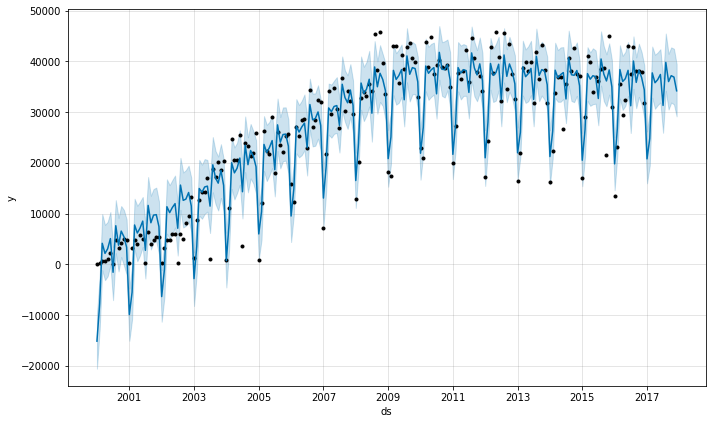

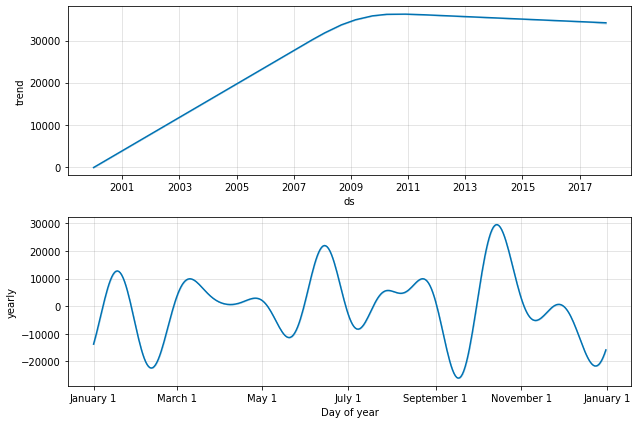

In [137]:
fig1 = mProphet.plot(forecastProphet[:])
fig2 = mProphet.plot_components(forecastProphet[:])

In [138]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
figProphet = plot_plotly(mProphet, forecastProphet)  # This returns a plotly Figure
#py.iplot(figProphet)
dfFaceForecast = forecastProphet

In [139]:
display(forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))

ds          yhat    yhat_lower    yhat_upper
213 2017-10-01  37174.733559  31880.259760  42757.368228
214 2017-11-01  36901.721866  31515.015135  42482.187047
215 2017-12-01  34196.321371  29156.748427  39477.363383

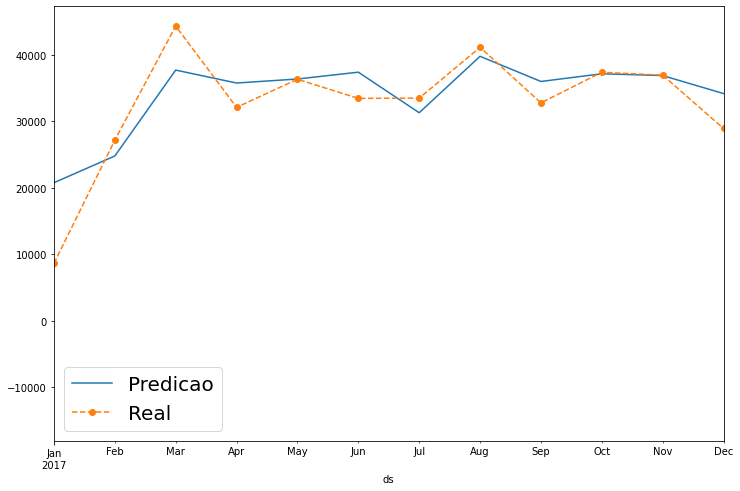

In [140]:
ax = forecastProphet.plot(x='ds',y='yhat',label='Predicao',legend=True,figsize=(12,8))
dfProphetTest.plot(x='ds',y='y',label='Real',legend=True,marker='o',style='--',ax=ax,xlim=('2017-01-01','2017-12-01'))

In [141]:
predictions = forecastProphet.iloc[-12:]['yhat']

In [142]:
predictionFacebook = pd.DataFrame(predictions)

FACEBOOK PROPHET:(204)                   4096.386767869377
FACEBOOK PROPHET:(12)                    4750.659776126323


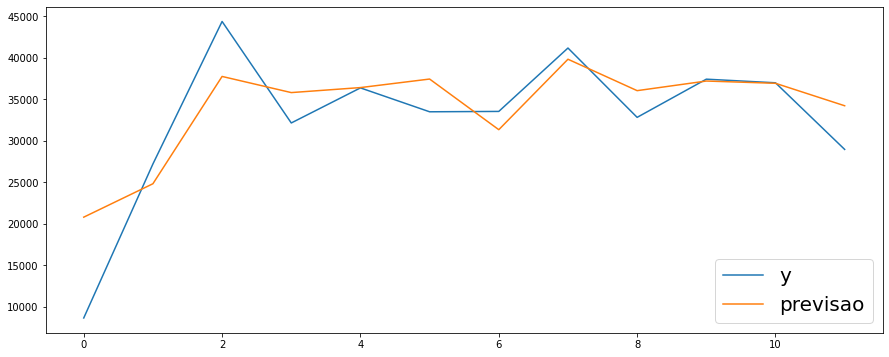

In [143]:
dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
dfProphetTest['y'].plot(figsize=(15,6),legend=True)
pd.Series(forecastProphet['yhat'][-12:].values).rename('previsao').plot(legend=True)

print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphet['y'][:-12]))+')',40), forecast_accuracy(dfProphet['y'][:-12].values,forecastProphet['yhat'][:-12].values)['rmse'])
print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphetTest['y']))+')',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])  


In [144]:
predictionFacebook1 = predictions.copy()
predictionFacebook1 = pd.DataFrame(predictionFacebook1)
d = pd.date_range(start='2017-01-01', end='2017-12-01', freq='MS')   
predictionFacebook1.index = d
predictionFacebook0 = predictionFacebook1.asfreq("MS")

#  PROPHET + ARIMA

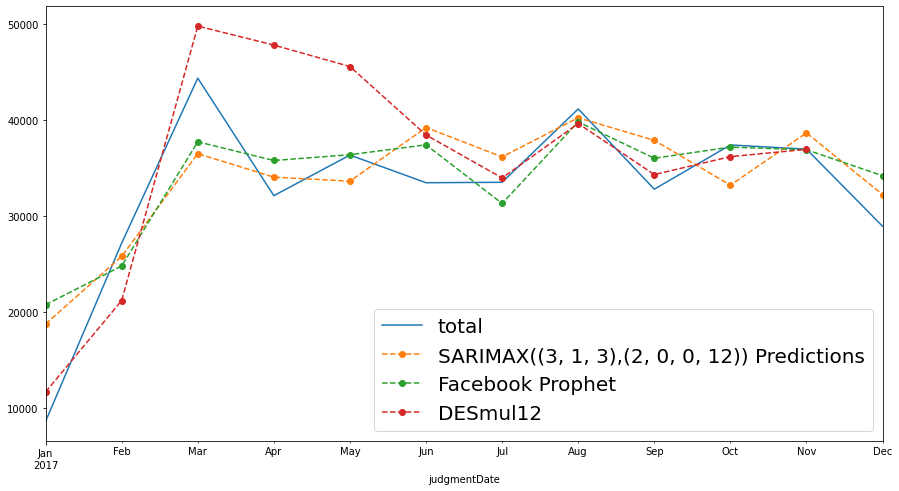

In [145]:
dfChoosed[field]['2017'].plot(legend=True)
predictionsARMANodiff.plot(style='--',legend=True,marker='o')
predictionFacebook0['yhat'].rename('Facebook Prophet').plot(style='--',legend=True,marker='o')
dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)]['2017'].plot(style='--',legend=True,marker='o').legend(fontsize=20)

In [146]:
for param in range(1,2):    
    mProphet = Prophet(daily_seasonality=1, weekly_seasonality=7,yearly_seasonality=365.5,changepoint_prior_scale=0.8,seasonality_mode='multiplicative',holidays=feriadosGerais)
    
    mProphet.add_seasonality(name='monthly', period=29, fourier_order=10)    
    mProphet.add_seasonality(name='weekly', period=7, fourier_order=10)
    #mProphet.add_seasonality(name='yearly', period=365.5, fourier_order=10)
    #mProphet.add_country_holidays(country_name='BR')        
    mProphet.fit(dfProphetTrain)
    print(mProphet.train_holiday_names)
    futureProphet = mProphet.make_future_dataframe(periods=predictFieldPeriod,freq=frequence)
    forecastProphet = mProphet.predict(futureProphet)
    forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    dfFaceForecast = forecastProphet
    
    predictions = forecastProphet.iloc[-12:]['yhat'] #prophet faz a predicao pra todo periodo
    
    print(rmse(predictions,dfProphetTest['y']),dfProphetTest['y'].mean())
    dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
    dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
    
    
    print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphet['y'][:-12]))+')',40), forecast_accuracy(dfProphet['y'][:-12].values,forecastProphet['yhat'][:-12].values)['rmse'])
    print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphetTest['y']))+')',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])

0        feriadosGauchos
1    feriadosAntecipados
dtype: object
3684.711329730626 32738.166666666668
FACEBOOK PROPHET:(204)                   2212.558402658522
FACEBOOK PROPHET:(12)                    3684.711329730626


FACEBOOK PROPHET:(204)                   2212.558402658522
FACEBOOK PROPHET:(12)                    3684.711329730626


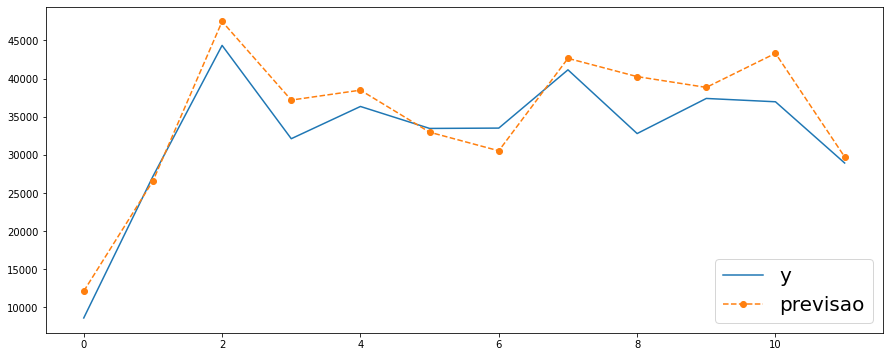

In [147]:
dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
dfProphetTest['y'].plot(figsize=(15,6),legend=True)
pd.Series(forecastProphet['yhat'][-12:].values).rename('previsao').plot(legend=True,marker='o',style='--')

print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphet['y'][:-12]))+')',40), forecast_accuracy(dfProphet['y'][:-12].values,forecastProphet['yhat'][:-12].values)['rmse'])
print(adjust('FACEBOOK PROPHET:('+ str(len(dfProphetTest['y']))+')',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])

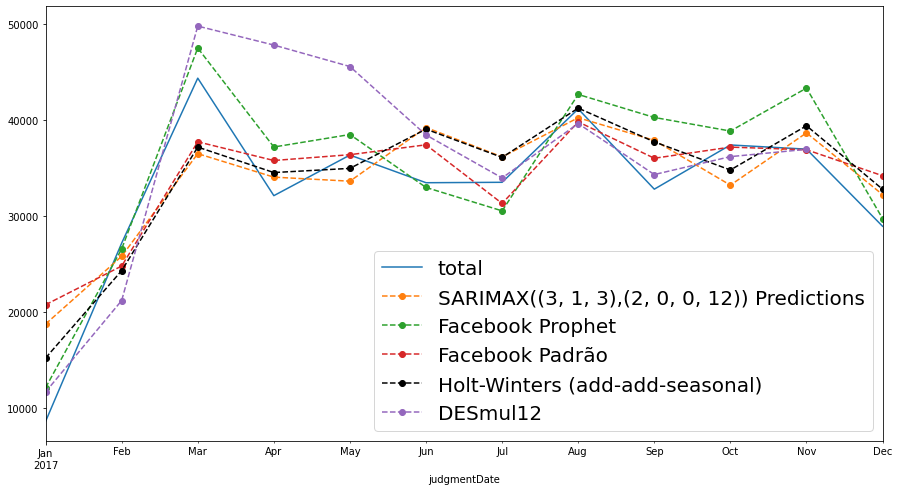

In [148]:
predictionFacebook1 = predictions.copy()
predictionFacebook1 = pd.DataFrame(pd.Series(forecastProphet['yhat'][-12:].values))
d = pd.date_range(start='2017-01-01', end='2017-12-01', freq='MS')   
predictionFacebook1.index = d
predictionFacebook1.columns = ['yhat']
#display(predictionFacebook1)


predictionFacebook1 = predictionFacebook1.asfreq("MS")
dfChoosed[field]['2017'].plot(legend=True)
predictionsARMANodiff.plot(style='--',marker='o',legend=True)
predictionFacebook1['yhat'].rename('Facebook Prophet').plot(style='--',legend=True,marker='o')
predictionFacebook0['yhat'].rename('Facebook Padrão').plot(style='--',legend=True,marker='o')
HwForeCastAddAdd.plot(style='--', marker='o', color='black', legend=True); 
dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)]['2017'].plot(style='--',legend=True,marker='o').legend(fontsize=20);

# Analise de periodicidade mensal

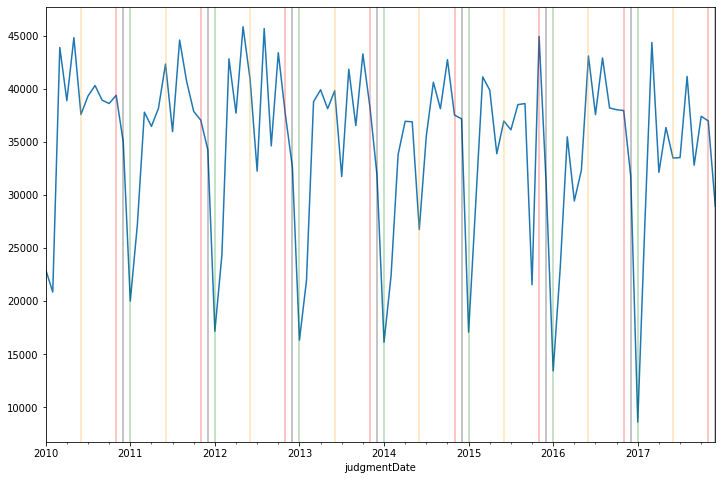

In [149]:
dfAnalise = dfChoosed[field]['2010':].copy()
dfAnalise = dfAnalise.reset_index()
dfAnalise.index = dfAnalise.judgmentDate
del dfAnalise['judgmentDate']
#display(dfAnalise[dfAnalise.index.month==12].index)

#display(pd.DataFrame(dfAnalise))
ax = dfAnalise['total'].plot(figsize=(12,8))
ax.autoscale(axis='x',tight=True)
for x in dfAnalise[dfAnalise.index.month==12].index: 
    ax.axvline(x=x, color='k', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==11].index: 
    ax.axvline(x=x, color='r', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==1].index: 
    ax.axvline(x=x, color='g', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==6].index: 
    ax.axvline(x=x, color='orange', alpha = 0.3);

# ANEXOS

# LSTM

Using TensorFlow backend.


Train Score: 3914.52 RMSE
Test Score: 5239.92 RMSE


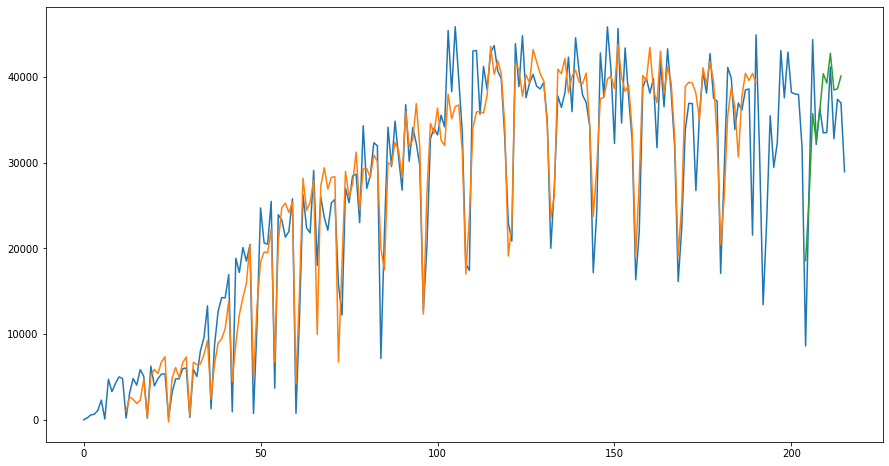

LTSM:                                    5239.915075814642


In [151]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

dataframe = dfChoosed[[field]]

dataset = dataframe.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * (16/17)+1)-12
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, 12)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()

model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print(adjust('LTSM: ',40), forecast_accuracy(testY[0], testPredict[:,0])['rmse'])

# PYTHON ACESSANDO R
## Para uso de funções não desenvolvidas em Python

In [152]:
import rpy2
print(rpy2.__version__)
from rpy2.robjects import default_converter,pandas2ri,r
from rpy2.robjects.conversion import Converter, localconverter
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

base = importr('nnet')
base = importr('forecast')
base = importr('base')
utils = importr('utils')
jurimetrics = importr('jurimetrics')
ts=robjects.r('ts')
pandas2ri.activate()

3.3.1


In [153]:
rdataAll = ts((dfChoosed[field]),frequency=12)
rdataTrain = ts((dfChoosed[field][:-predictFieldPeriod]),frequency=12)
rdataTest = ts((dfChoosed[field][-predictFieldPeriod:]),frequency=12)

print(len(rdataTrain))
print(len(rdataTest))

204
12


In [154]:
d = pd.date_range(start='2000-01-01', end='2030-12-01', freq='MS')   

frequence = ''

if dfChoosed[field]['2016'].count() == 12:
    frequence = 'MS'

if dfChoosed[field]['2016'].count() == 4:
    frequence = 'QS'
    
if dfChoosed[field]['2016'].count() == 1:
    frequence = 'A'
    
robjects.globalenv['r_timeseriesTrain'] = rdataTrain
robjects.globalenv['r_timeseriesAll'] = rdataAll

# NNETAR

12 12
NNETAR:                                  5256.710889510826


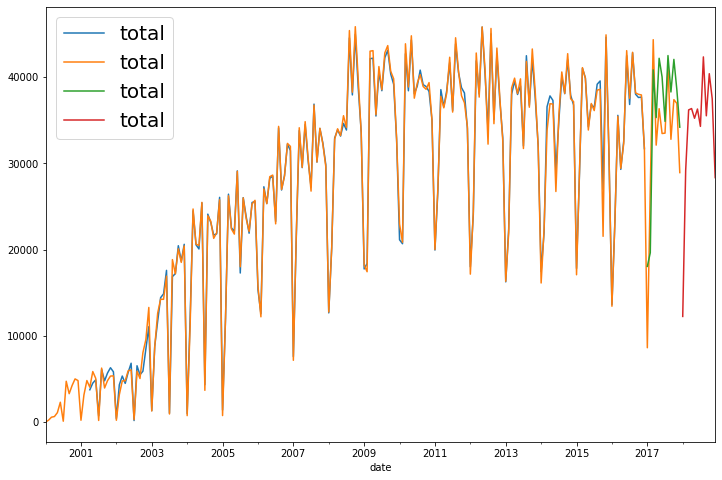

In [155]:
pred2NNETAR = robjects.r('(forecast::nnetar(r_timeseriesTrain))')
fcastNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseriesTrain),h='+str(predictFieldPeriod)+'))')

fcastFutureNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseriesAll),h='+str(predictFieldPeriod)+'))')

dfR = pd.DataFrame(pd.Series(d[0:len(pred2NNETAR[9])]))
dfNNetarFC = pd.DataFrame(pd.Series(d[len(pred2NNETAR[9]):len(pred2NNETAR[9])+predictFieldPeriod]))
dfNNetarFCFuture = pd.DataFrame(pd.Series(d[len(rdataAll):len(rdataAll)+predictFieldPeriod]))


dfR[field] = pd.Series(pred2NNETAR[9]).values
dfNNetarFC[field] = fcastNNetar.values
dfNNetarFCFuture[field] = fcastFutureNNetar.values

dfR.columns=['date',field]
dfR.index = pd.to_datetime(dfR['date'])
dfR.freq = frequence
dfR = dfR[[field]]

dfNNetarFC.columns=['date',field]
dfNNetarFC.index = pd.to_datetime(dfNNetarFC['date'])
dfNNetarFC.freq = frequence
dfNNetarFC = dfNNetarFC[[field]]

dfNNetarFCFuture.columns=['date',field]
dfNNetarFCFuture.index = pd.to_datetime(dfNNetarFCFuture['date'])
dfNNetarFCFuture.freq = frequence
dfNNetarFCFuture = dfNNetarFCFuture[[field]]

dfR.plot(legend=True,figsize=figsize)
dfChoosed[field].plot(legend=True)
dfNNetarFC[field].plot(legend=True)
dfNNetarFCFuture[field].plot(legend=True)

print(len(rdataTest),len(dfNNetarFC[field].values))
print(adjust('NNETAR: ',40), forecast_accuracy(rdataTest,dfNNetarFC[field].values)['rmse'])


12 12
TBATS:                                   8426.752907262886


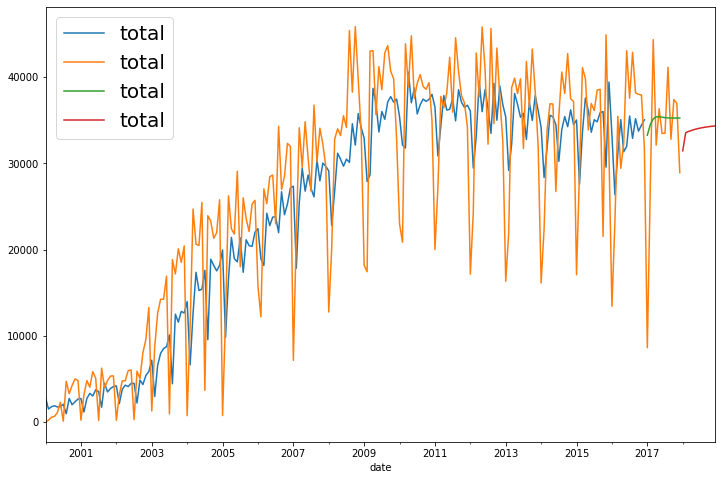

In [156]:
pred2TBATS = robjects.r('(forecast::tbats(r_timeseriesTrain))')
fcasttTBATS = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseriesTrain),h='+str(predictFieldPeriod)+'))')
fcastFutureTBATS = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseriesAll),h='+str(predictFieldPeriod)+'))')

#display(pred2TBATS[13])

dfRTBATS = pd.DataFrame(pd.Series(d[0:len(pred2TBATS[13])]))
dfTBATS = pd.DataFrame(pd.Series(d[len(pred2TBATS[13]):len(pred2TBATS[13])+predictFieldPeriod]))
dfTBATSFuture = pd.DataFrame(pd.Series(d[len(rdataAll):len(rdataAll)+predictFieldPeriod]))

coluna = fcasttTBATS.columns[0]

dfRTBATS[field] = pd.DataFrame(pd.Series(pred2TBATS[13]))
dfTBATS[field] = fcasttTBATS[coluna].values
dfTBATSFuture[field] = fcastFutureTBATS[coluna].values

dfRTBATS.columns=['date',field]
dfRTBATS.index = pd.to_datetime(dfRTBATS['date'])
dfRTBATS.freq = frequence
dfRTBATS = dfRTBATS[[field]]

dfTBATS.columns=['date',field]
dfTBATS.index = pd.to_datetime(dfTBATS['date'])
dfTBATS.freq = frequence
dfTBATS = dfTBATS[[field]]

dfTBATSFuture.columns=['date',field]
dfTBATSFuture.index = pd.to_datetime(dfTBATSFuture['date'])
dfTBATSFuture.freq = frequence
dfTBATSFuture = dfTBATSFuture[[field]]

dfRTBATS.plot(legend=True,figsize=figsize)
dfChoosed[field].plot(legend=True)
dfTBATS[field].plot(legend=True)
dfTBATSFuture[field].plot(legend=True)

print(len(rdataTest),len(dfTBATS[field].values))
print(adjust('TBATS: ',40), forecast_accuracy(rdataTest,dfTBATS[field].values)['rmse'])